# 1. Data Exploration
First, we explore the dataset and perform some descriptive analysis

## Import necessary packages

In [930]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats  
import xlrd
import datetime as dt

# % matplotlib inline

# feature engineering
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# model training
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# model evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# classifiers
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.linear_model import LogisticRegression # logistic regression
from sklearn.tree import DecisionTreeClassifier # decision tree
from sklearn.ensemble import RandomForestClassifier # random forest
from sklearn.ensemble import GradientBoostingClassifier # gradient boosting

## Read CSV File

In [931]:
df = pd.read_csv('data/loan.csv',low_memory=True)
df.head()

/Users/chihongtao/anaconda/envs/notebook/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,nan,nan,2500,2500,2500.0000000000,36 months,13.5600000000,84.9200000000,C,C1,...,nan,nan,Cash,N,NaN,NaN,NaN,nan,nan,nan
1,nan,nan,30000,30000,30000.0000000000,60 months,18.9400000000,777.2300000000,D,D2,...,nan,nan,Cash,N,NaN,NaN,NaN,nan,nan,nan
2,nan,nan,5000,5000,5000.0000000000,36 months,17.9700000000,180.6900000000,D,D1,...,nan,nan,Cash,N,NaN,NaN,NaN,nan,nan,nan
3,nan,nan,4000,4000,4000.0000000000,36 months,18.9400000000,146.5100000000,D,D2,...,nan,nan,Cash,N,NaN,NaN,NaN,nan,nan,nan
4,nan,nan,30000,30000,30000.0000000000,60 months,16.1400000000,731.7800000000,C,C4,...,nan,nan,Cash,N,NaN,NaN,NaN,nan,nan,nan


## Check column info and NULL values

In [932]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260668 entries, 0 to 2260667
Data columns (total 145 columns):
 #   Column                                      Non-Null Count    Dtype  
---  ------                                      --------------    -----  
 0   id                                          0 non-null        float64
 1   member_id                                   0 non-null        float64
 2   loan_amnt                                   2260668 non-null  int64  
 3   funded_amnt                                 2260668 non-null  int64  
 4   funded_amnt_inv                             2260668 non-null  float64
 5   term                                        2260668 non-null  object 
 6   int_rate                                    2260668 non-null  float64
 7   installment                                 2260668 non-null  float64
 8   grade                                       2260668 non-null  object 
 9   sub_grade                                   2260668 non-

## Distribution of loan amount, term, year

<ipython-input-933-2fb512dd40ec>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = plt.axes()


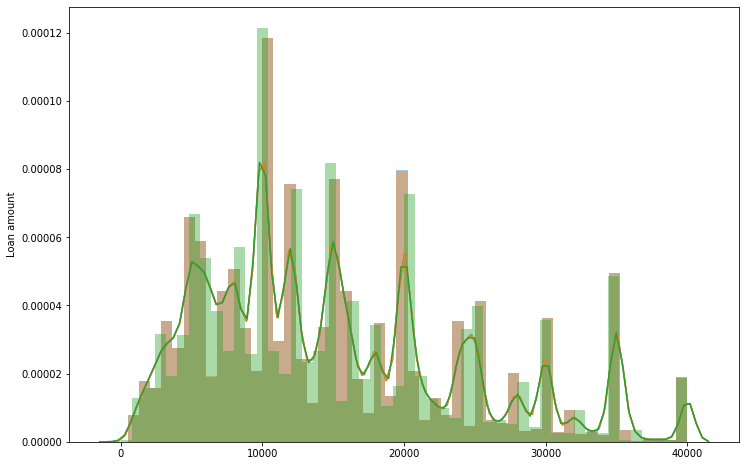

In [933]:
plt.figure(figsize=(12,8))
# Plot the distribution of loan amount applied by borrower
sns.distplot(df['loan_amnt'])
# Plot the distribution loan amount committeed
sns.distplot(df['funded_amnt'])
# Plot the distribution of loan amount committed by investors
sns.distplot(df['funded_amnt_inv'])
plt.ylabel('Loan amount')
ax1 = plt.axes()
x_axis = ax1.axes.get_xaxis()
x_label = x_axis.get_label()
x_label.set_visible(False)

 36 months   0.7120700607
 60 months   0.2879299393
Name: term, dtype: float64


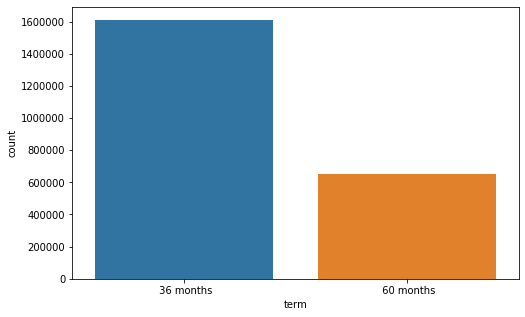

In [934]:
# Plot the term of the loans applied, in terms of percentage over all loans
print (df['term'].value_counts(normalize=True))
plt.figure(figsize=(8,5))
sns.countplot(df['term'])

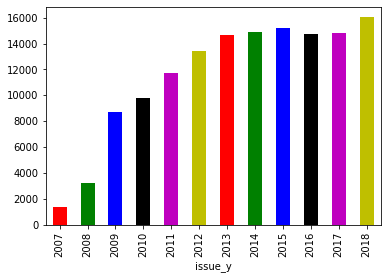

In [935]:
# Extract the year & month from issue_d and plot the average loan amount with respect to year
df['issue_y'] = pd.to_datetime(df['issue_d'], format='%b-%Y', errors='coerce').apply(lambda x: x.year)
df['issue_m'] = pd.to_datetime(df['issue_d'], format='%b-%Y', errors='coerce').apply(lambda x: x.month)
# Plot the funded loan amount by year
df.groupby('issue_y')['funded_amnt_inv'].mean().plot(kind='bar',color=['r', 'g', 'b', 'k', 'm', 'y'])
# sns.lineplot(df.groupby('issue_y')['funded_amnt_inv'].mean().index, df.groupby('issue_y')['funded_amnt_inv'].mean().values)

### Observation
* Loan amount applied follows a multi-nomial distribution, mostly falling within 10k - 20k range
* Loan amount applied, funded and funded_invested follows similar distributions, this means most loans applied by eligible borrowers are approved and funded by investor 
* _71%_ of the loans applied are for _36_ months, while _29%_ are for _60_ months.
* Average loan amount increases each year, with significant jump in _2009, peak around 2015-2018_. This is probably due to financial crisis in _2008_ , which resulted in low interest rate between _2009-2018_

In [936]:
# Inspect loan status
df['loan_status'].value_counts()

Fully Paid                                             1041952
Current                                                 919695
Charged Off                                             261655
Late (31-120 days)                                       21897
In Grace Period                                           8952
Late (16-30 days)                                         3737
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     31
Name: loan_status, dtype: int64

## Good Loan v.s. Bad Loan

* We categorise the loan as a bad loan if the loan status is any of these: _["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off", "In Grace Period", "Late (16-30 days)", "Late (31-120 days)"]_
* Also, there is a significant number of loans that are under the status of __"Current"__, which we cannot tell whether it is a good / bad loan. Hence, we need to __remove such loans__ before splitting into training/test dataset.
* With this categorisation, we can see _13%_ of the loans are bad loans. Hence, this is a very __imbalanced dataset__, with large number of negatives if we are predicting bad loans
* However, we have to keep in mind that some of the "good" loans are still in the process of getting paid, especially loans that are more recent in this time horizon. Hence, we observe higher percentage of good loans from _2016-2018_. But these may turn bad later.

[Text(0, 0.5, '(%)')]

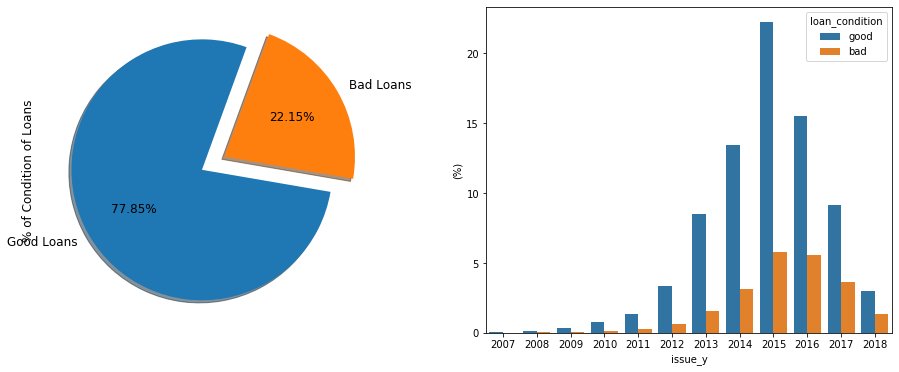

In [937]:
# Remove loans under "Current" status
df = df[df['loan_status']!='Current']

# We can categorise the loan as good / bad loan. 
# From the pie chart, 13% of the loans are bad loans
f, ax = plt.subplots(1,2, figsize=(16,6))
labels ="Good Loans", "Bad Loans"
bad_loan_statuses = ["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off", \
                     "In Grace Period", "Late (16-30 days)", "Late (31-120 days)"]
df['loan_condition'] = df['loan_status'].apply(lambda x: 'bad' if x in bad_loan_statuses else 'good')
df['loan_condition'].value_counts().plot(kind='pie', explode=[0,0.2], autopct='%1.2f%%',\
                                         ax=ax[0], labels=labels, fontsize=12, startangle=70, shadow=True)
ax[0].set_ylabel('% of Condition of Loans', fontsize=12)

sns.barplot(x="issue_y", y="loan_amnt", hue="loan_condition", data=df,\
            estimator=lambda x: len(x) / len(df) * 100)
ax[1].set(ylabel="(%)")

## Plotting loans for each state

We can see that Lending clubs borrowers are most active in the few states where economy is doing well, e.g. California, Texas, New York, Florida, Illinois etc. While the states with lowest amount of loans are mostly in the Mid-West, such as North Dakota, Idaho, South Dakota etc. 

Text(0.5, 0, 'State')

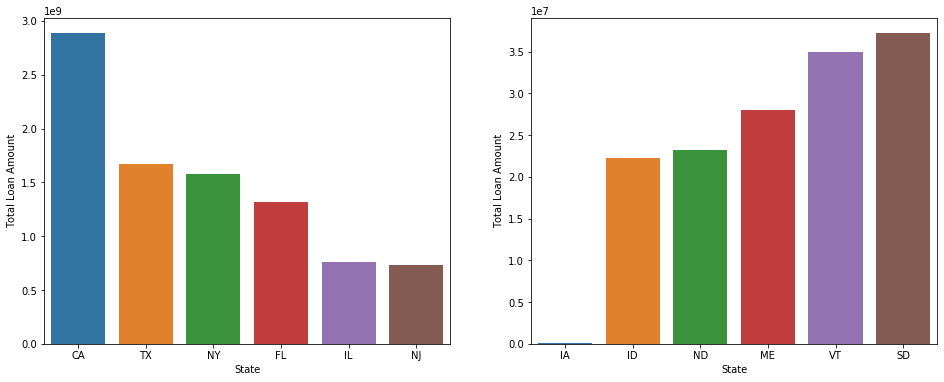

In [938]:
# Examine which state has the highest & lowest amount of loan in total
group_date = df.groupby(['addr_state'],as_index=False)['loan_amnt'].sum()
top_6_states = group_date.sort_values('loan_amnt',ascending=False).iloc[0:6]
btm_6_states = group_date.sort_values('loan_amnt').iloc[0:6]
fig, axs = plt.subplots(1,2, figsize=(16,6))
sns.barplot(x='addr_state', y='loan_amnt',data=top_6_states, ax=axs[0])
sns.barplot(x='addr_state', y='loan_amnt',data=btm_6_states, ax=axs[1])
axs[0].set_ylabel("Total Loan Amount")
axs[0].set_xlabel("State")
axs[1].set_ylabel("Total Loan Amount")
axs[1].set_xlabel("State")

### Observation
By plotting the loan condition splits for the top 6 & bottomr 6 states, we can see that states differ in the percentage of bad loans. 
* For the top 6 states in terms of loan amount, most of them have close to the overall average (~13%) of bad loans. 
* While for the bottom 6 states, the generally have less than the average % of bad loans. This could be due to these states being more financially conservative. 
* This means that state has a bearing on the percentage of good v.s. bad loans somehow

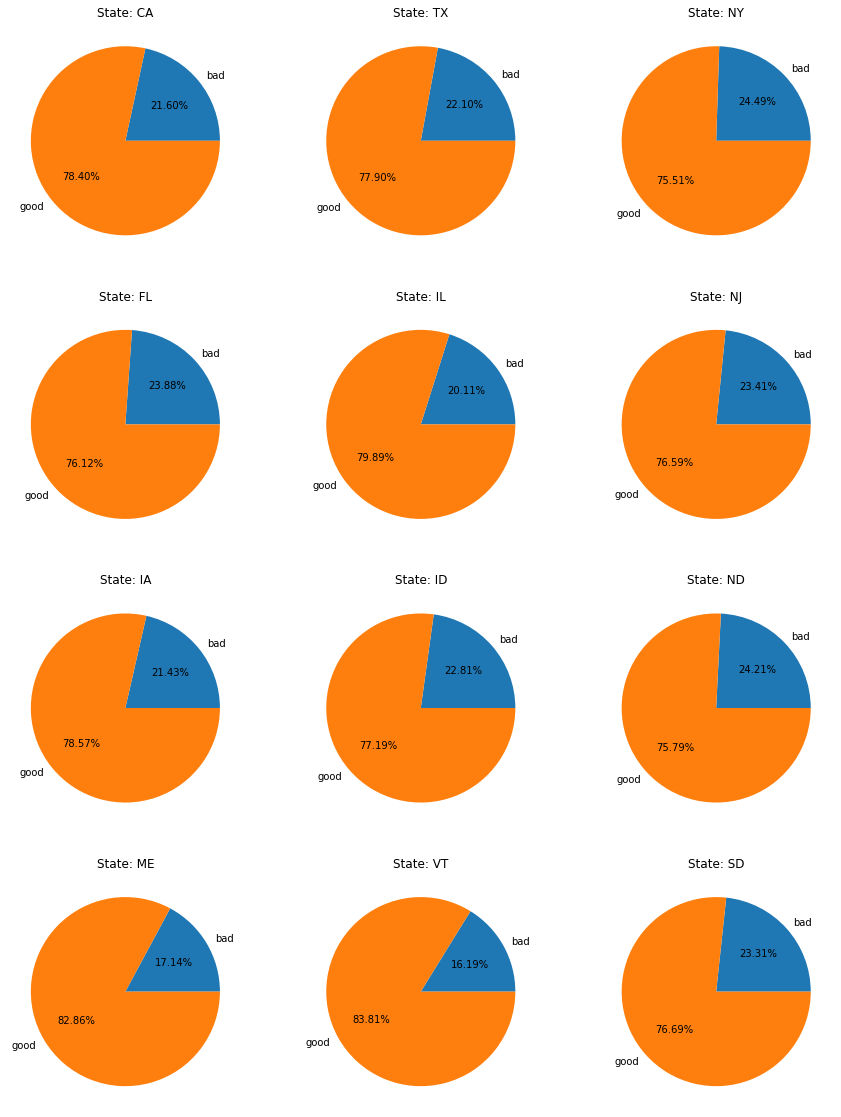

In [939]:
top_6_ls = list(top_6_states['addr_state'])
btm_6_ls = list(btm_6_states['addr_state'])
state_loan_condition = df.groupby('addr_state')['loan_condition'].value_counts(normalize=True).\
              unstack().reset_index().rename_axis(None, axis=1).set_index('addr_state')
plot_df = pd.concat([state_loan_condition.loc[top_6_ls], state_loan_condition.loc[btm_6_ls]])
# plot_df = state_loan_condition[~state_loan_condition.index.isin(['IA'])]
# print (plot_df.count())
# plot the pie good & bad loan percentage for the top 6 & bottom 6 states
fig = plt.figure(figsize=(15,20))
# print (state_loan_condition.count())
for i, (name, row) in enumerate(plot_df.iterrows()):
    ax = plt.subplot(4,3, i+1)
    ax.set_title("State: %s"%row.name)
    ax.set_aspect('equal')
    ax.pie(row, labels=row.index, autopct='%1.2f%%')

## Loan metrics by region
Hence, we decided to break down the country into four regions based on geography and plot some of the descriptive metrics for each region.

Text(0.5, 0, 'Year')

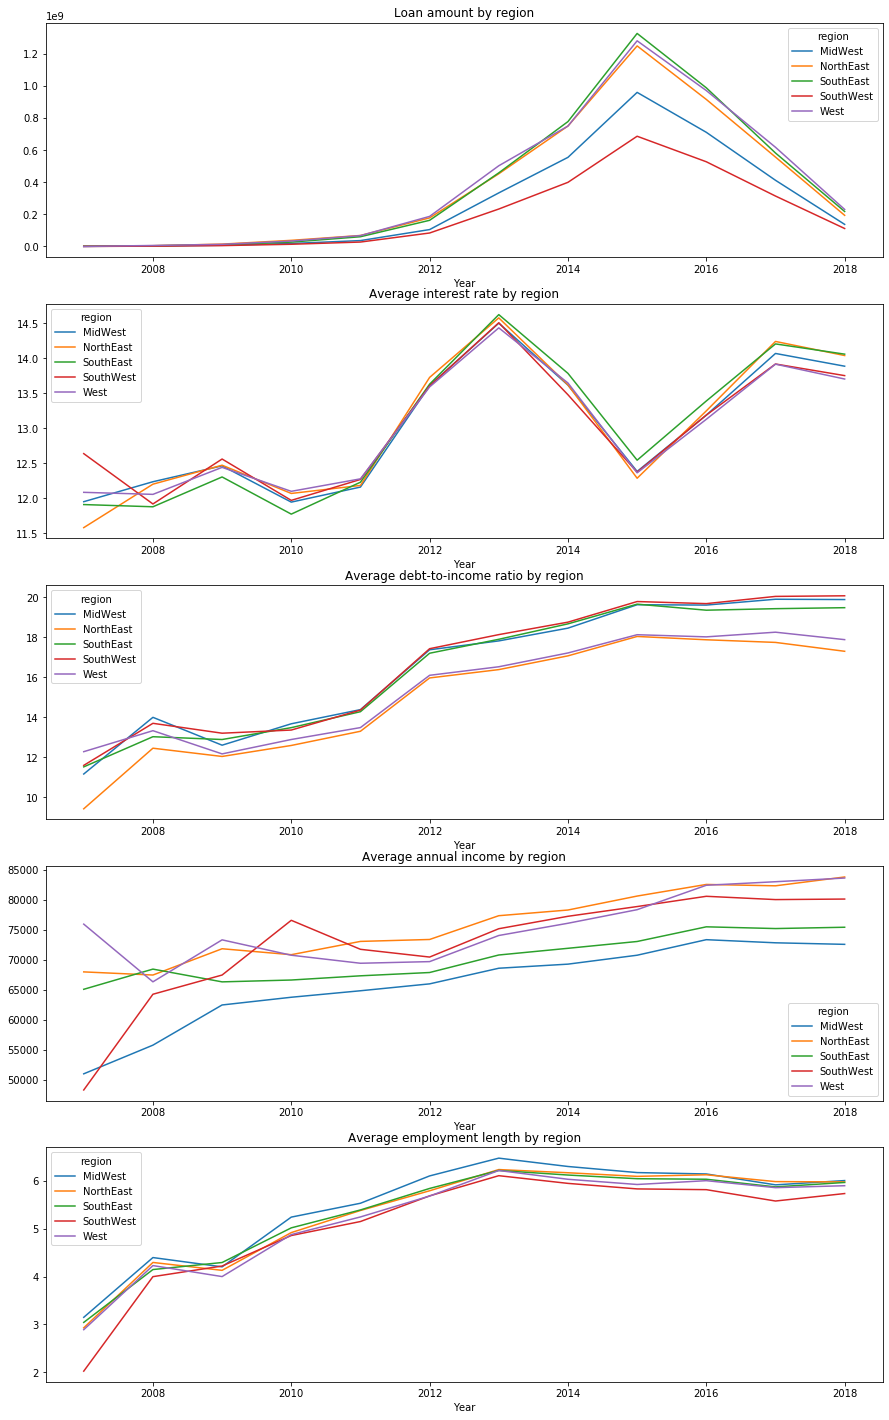

In [940]:
west = ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID']
south_west = ['AZ', 'TX', 'NM', 'OK']
south_east = ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN' ]
mid_west = ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND']
north_east = ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']

df['region'] = np.nan

def finding_regions(state):
    if state in west:
        return 'West'
    elif state in south_west:
        return 'SouthWest'
    elif state in south_east:
        return 'SouthEast'
    elif state in mid_west:
        return 'MidWest'
    elif state in north_east:
        return 'NorthEast'

df['region'] = df['addr_state'].apply(finding_regions)
    
df['emp_length_int'] = np.nan

def update_emp_length_int(emp_length):
    emp_length_int = None
    if emp_length == '10+ years':
        emp_length_int = 10
    elif emp_length == '9 years':
        emp_length_int = 9
    elif emp_length == '8 years':
        emp_length_int = 8
    elif emp_length == '7 years':
        emp_length_int = 7
    elif emp_length == '6 years':
        emp_length_int = 6
    elif emp_length == '5 years': 
        emp_length_int = 5
    elif emp_length == '4 years':
        emp_length_int = 4
    elif emp_length == '3 years':
        emp_length_int = 3
    elif emp_length == '2 years': 
        emp_length_int = 2
    elif emp_length == '1 year':
        emp_length_int = 1
    elif emp_length == '< 1 year':
        emp_length_int = 0.5
    elif emp_length == 'n/a':
        emp_length_int = 0    
    return emp_length_int

df['emp_length_int'] = df['emp_length'].apply(update_emp_length_int)

# plt.style.use('dark_background')
f, ax = plt.subplots(5,1, figsize=(15,25))

grouped_df = df.groupby(['issue_y','region'])

loan_by_region = grouped_df.loan_amnt.sum()
# loan_by_region_date.head()
loan_by_region.unstack().plot(ax=ax[0], stacked=False)
ax[0].set_title('Loan amount by region')
ax[0].set_xlabel('Year')

int_rate_by_region = grouped_df.int_rate.mean()
int_rate_by_region.unstack().plot(ax=ax[1])
ax[1].set_title('Average interest rate by region')
ax[1].set_xlabel('Year')

dti_by_region = grouped_df.dti.mean()
dti_by_region.unstack().plot(ax=ax[2])
ax[2].set_title('Average debt-to-income ratio by region')
ax[2].set_xlabel('Year')

income_by_region = grouped_df.annual_inc.mean()
income_by_region.unstack().plot(ax=ax[3])
ax[3].set_title('Average annual income by region')
ax[3].set_xlabel('Year')

emp_length_by_region = grouped_df.emp_length_int.mean()
emp_length_by_region.unstack().plot(ax=ax[4])
ax[4].set_title('Average employment length by region')
ax[4].set_xlabel('Year')

### Observation
* SouthEast, West, NorthEast have the highest total loans amounts for most of the years, while SouthWest has the lowest 
* This also corresponds to the average interest rate per year, where SouthEast & NorthEast are the highest in most years. This means loans in SouthEast & NorthEast tend to give higher returns 
* Despite the low total loan amounts, SouthWest has the highest debt to income ratio. While NorthEast & West have rather low debt-to-income ratio
* NorthEast & West have the highest average annual income, which might explain their low debt-to-income ratio
* MidWest has the highest average employment length, but annual income are the lowest 

## Loan condition by region
Here, we plot the loan condition - good / bad, for each region, similar to how we plotted by states

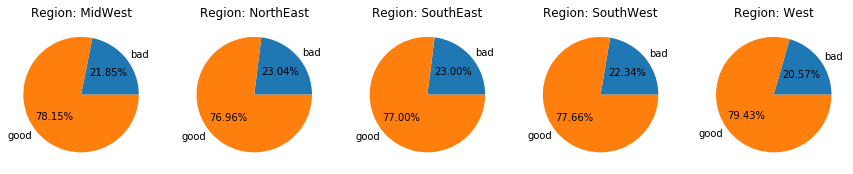

In [941]:
reg_loan_condition = df.groupby('region')['loan_condition'].value_counts(normalize=True).\
              unstack().reset_index().rename_axis(None, axis=1).set_index('region')
# plot the pie good & bad loan percentage for each region
fig = plt.figure(figsize=(15,20))
# print (state_loan_condition.count())
for i, (name, row) in enumerate(reg_loan_condition.iterrows()):
    ax = plt.subplot(1,5, i+1)
    ax.set_title("Region: %s"%row.name)
    ax.set_aspect('equal')
    ax.pie(row, labels=row.index, autopct='%1.2f%%')

Let's have a closer look at breakdown of __bad loans__ for each region. We can see that for each state, majority of the bad loans are charged off. 

<Figure size 1080x2160 with 0 Axes>

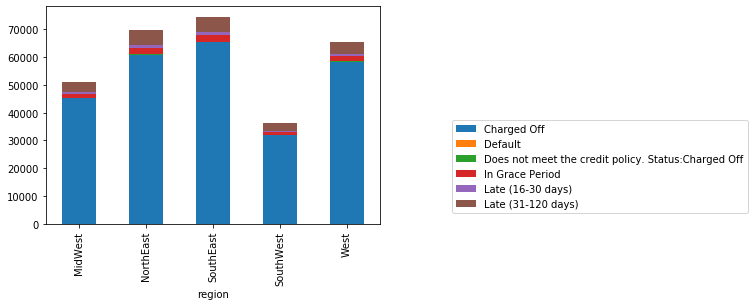

In [942]:
bad_loan_df = df[df['loan_condition']=='bad']
# print (pd.crosstab(bad_loan_df['region'], bad_loan_df['loan_status']))
fig = plt.figure(figsize=(15,30))
bad_loan_df.groupby(['region','loan_status'])['loan_amnt'].count().unstack().plot(kind='bar',stacked=True).legend(bbox_to_anchor=(1.2, 0.5))

# 2. Data Pre-processing

Next, we will perform data pre-processing to prepare the data to be used for prediction

## Split the data into Train, Test set
First, we split the dataframe into x - variables, y - labels (whether the loan is a good / bad loan). Here, we classify these loan status as bad loans, for which either the borrower is not able to pay back, or is late in payment. For this, we will use the newly created column: loan_condition, which will be the y label in our dataset. Later during training, we also need to __drop loan_status column__ from the x variables, because of its correlation with the label column.

In [943]:
y = df['loan_condition']
x = df.drop(columns=['loan_condition'])
# print (df.shape)
# print (x.shape)
# print (y.shape)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=0)
# print (x_train.shape)
# print (x_test.shape)
# print (y_train.shape)
# print (y_test.shape)
df_train = x_train.merge(y_train, left_index=True, right_index=True)
df_test = x_test.merge(y_test, left_index=True, right_index=True)
print (df_train.info(verbose=True, null_counts=True))
print (df_test.info(verbose=True, null_counts=True))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1005729 entries, 1832470 to 868271
Data columns (total 150 columns):
 #   Column                                      Non-Null Count    Dtype  
---  ------                                      --------------    -----  
 0   id                                          0 non-null        float64
 1   member_id                                   0 non-null        float64
 2   loan_amnt                                   1005729 non-null  int64  
 3   funded_amnt                                 1005729 non-null  int64  
 4   funded_amnt_inv                             1005729 non-null  float64
 5   term                                        1005729 non-null  object 
 6   int_rate                                    1005729 non-null  float64
 7   installment                                 1005729 non-null  float64
 8   grade                                       1005729 non-null  object 
 9   sub_grade                                   1005729

<class 'pandas.core.frame.DataFrame'>
Int64Index: 335244 entries, 733217 to 698290
Data columns (total 150 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   id                                          0 non-null       float64
 1   member_id                                   0 non-null       float64
 2   loan_amnt                                   335244 non-null  int64  
 3   funded_amnt                                 335244 non-null  int64  
 4   funded_amnt_inv                             335244 non-null  float64
 5   term                                        335244 non-null  object 
 6   int_rate                                    335244 non-null  float64
 7   installment                                 335244 non-null  float64
 8   grade                                       335244 non-null  object 
 9   sub_grade                                   335244 non-null  obj

## Pre-processing of the training / test data
From above information, we can see for quite a few columns, there are significant number of rows with null values. This is common for both the training and test dataset. Next, we will attempt to reduce some of the less useful columns, and also remove some outliers records.

First, we try to reduce the feature set by checking how many columns has less than 30% of non-null values, and only keeping those. 

(1340973, 150)
(58,)


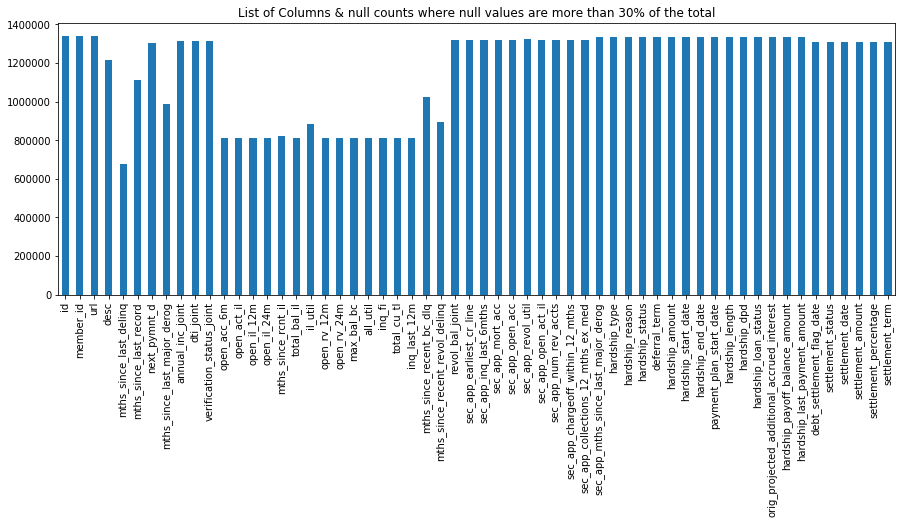

In [944]:
print (df.shape)
null_col = df.isnull().sum()
null_col = null_col[null_col.values >(0.3*len(df))]
print (null_col.shape)
plt.figure(figsize=(15,5))
null_col.plot(kind='bar')
plt.title('List of Columns & null counts where null values are more than 30% of the total')
plt.show()

From above plot, we can see that out of the 151 columns from the original dataset, 58 columns have more than 30% of the rows with nul values. We will hence drop these 58 columns in both the training and test dataset, since too many null values will not help much in our training and prediction.

In [945]:
df_train.drop(columns=list(null_col.index), inplace=True)
print (df_train.shape)
df_test.drop(columns=list(null_col.index), inplace=True)
print (df_test.shape)

(1005729, 92)
(335244, 92)


Similarly, we check if there are any rows that have less than 30% of non-null values populated. We will go ahead and remove those rows

In [946]:
# Drop rows with too many null values, for training data
df_transposed = df_train.transpose()
null_rows = df_transposed.isnull().sum()
null_rows = null_rows[null_rows.values >(0.3*len(df_transposed))]
print (null_rows.shape)
df_train.drop(axis=0, labels=list(null_rows.index), inplace=True)
print (df_train.shape)

# Drop rows with too many null values, for test data
df_transposed = df_test.transpose()
null_rows = df_transposed.isnull().sum()
null_rows = null_rows[null_rows.values >(0.3*len(df_transposed))]
print (null_rows.shape)
df_test.drop(axis=0, labels=list(null_rows.index), inplace=True)
print (df_test.shape)

(37705,)
(968024, 92)
(12742,)
(322502, 92)


After dropping null columns & rows, we check for columns where there is only one unique values. Those are not very useful in prediction, and hence we will remove those as well. We will do this for both the training and test dataset

In [947]:
unique = df_train.nunique()
df_train.drop(axis=1, labels=list(unique[unique==1].index), inplace=True)
print (unique[unique==1])
print (df_train.shape)

unique = df_test.nunique()
df_test.drop(axis=1, labels=list(unique[unique==1].index), inplace=True)
print (unique[unique==1])
print (df_test.shape)

policy_code    1
dtype: int64
(968024, 91)
policy_code    1
dtype: int64
(322502, 91)


Next, we handle a few specific columns. We will do below for both the training & test dataset.
* For employment length column, we will fill the null values with 0.
* We will also drop the zip code column, as geographical information is already contained in state (addr_state) field.

In [948]:
# print (df_unique.emp_length.value_counts(dropna=False))
df_train.emp_length.fillna(0, inplace=True)
df_test.emp_length.fillna(0,inplace=True)
df_train.drop(columns='zip_code',inplace=True)
df_test.drop(columns='zip_code',inplace=True)
print (df_train.shape)
print (df_test.shape)

(968024, 90)
(322502, 90)


Next, we derive some useful columns based on domain understanding, which we believe can be useful for our training and prediction, including creating range variables for some of the most commonly used varables, such as loan_amnt, annual_inc, int_rate. We do this for both the training and test dataset. 

In [949]:
# Calculate the ratio of loan to annual income, as an indication of the risk for the borrower
df_train['loan_to_income_ratio'] = df_train['loan_amnt'] / df_train['annual_inc']
df_test['loan_to_income_ratio'] = df_test['loan_amnt'] / df_test['annual_inc']
# In the previous section on explorative data analysis, we also added columns like issue_y, issue_m, region
# pd.set_option('float_format', '{:f}'.format)
# df_unique.describe()

# Create bins for loan amount, annual income, interest rate
bins = [0, 5000, 10000, 15000, 20000, 25000,40000]
slot = ['0-5000', '5000-10000', '10000-15000', '15000-20000', '20000-25000','25000 and above']
df_train['loan_amnt_range'] = pd.cut(df_train['loan_amnt'], bins, labels=slot)
df_test['loan_amnt_range'] = pd.cut(df_test['loan_amnt'], bins, labels=slot)

bins = [-1, 25000, 50000, 75000, 100000,110000000]
slot = ['0-25000', '25000-50000', '50000-75000', '75000-100000', '100000 and above']
df_train['annual_inc_range'] = pd.cut(df_train['annual_inc'], bins, labels=slot)
df_test['annual_inc_range'] = pd.cut(df_test['annual_inc'], bins, labels=slot)

bins = [0, 7.5, 10, 12.5, 15,35]
slot = ['0-7.5', '7.5-10', '10-12.5', '12.5-15', '15 and above']
df_train['int_rate_range'] = pd.cut(df_train['int_rate'], bins, labels=slot)
df_test['int_rate_range'] = pd.cut(df_test['int_rate'], bins, labels=slot)

print (df_train.shape)
print (df_test.shape)

(968024, 94)
(322502, 94)


In [950]:
df_train.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 968024 entries, 1832470 to 868271
Data columns (total 94 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   loan_amnt                   968024 non-null  int64   
 1   funded_amnt                 968024 non-null  int64   
 2   funded_amnt_inv             968024 non-null  float64 
 3   term                        968024 non-null  object  
 4   int_rate                    968024 non-null  float64 
 5   installment                 968024 non-null  float64 
 6   grade                       968024 non-null  object  
 7   sub_grade                   968024 non-null  object  
 8   emp_title                   905986 non-null  object  
 9   emp_length                  968024 non-null  object  
 10  home_ownership              968024 non-null  object  
 11  annual_inc                  968024 non-null  float64 
 12  verification_status         968024 non-null  object 

## Univariate Analysis - continuous variable

Then, we will perform some __univariate analysis__ on both continuous and categorical variables, in order to remove outliers to further trim down on the number of rows. 

First, we examine of some of the key continuous variables, namely Loan Amount, Interest Rate, Annual Income

(962406, 94)
(320715, 94)


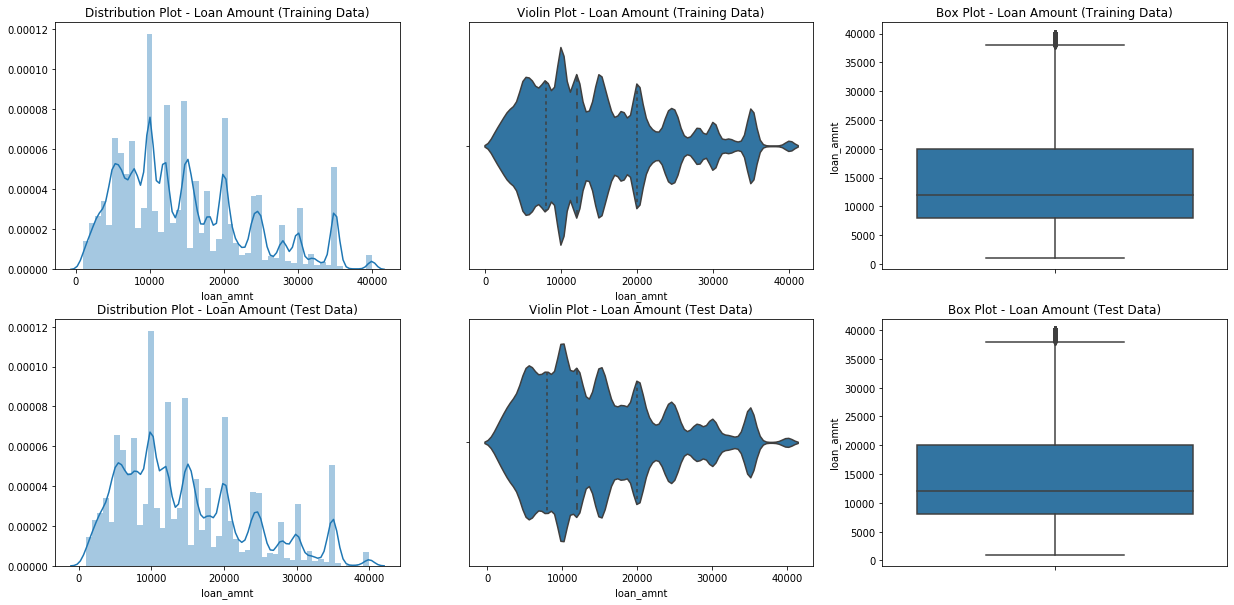

In [951]:
# Plotting for Loan Amount, in training dataset
fig, ax = plt.subplots(2,3,figsize=(21,10))
ax[0][0].set_title("Distribution Plot - Loan Amount (Training Data)")
sns.distplot(df_train['loan_amnt'],ax=ax[0][0])
ax[0][1].set_title("Violin Plot - Loan Amount (Training Data)")
sns.violinplot(data=df_train, x='loan_amnt',ax=ax[0][1], inner="quartile")
ax[0][2].set_title("Box Plot - Loan Amount (Training Data)")
sns.boxplot(data=df_train, x='loan_amnt',ax=ax[0][2],orient='v')

# Plottting for Loan Amount, in test dataset
ax[1][0].set_title("Distribution Plot - Loan Amount (Test Data)")
sns.distplot(df_test['loan_amnt'],ax=ax[1][0])
ax[1][1].set_title("Violin Plot - Loan Amount (Test Data)")
sns.violinplot(data=df_test, x='loan_amnt',ax=ax[1][1], inner="quartile")
ax[1][2].set_title("Box Plot - Loan Amount (Test Data)")
sns.boxplot(data=df_test, x='loan_amnt',ax=ax[1][2],orient='v')

# Extract outliers from the boxplot and remove the rows from training dataset
outlier_train_loan_amnt = boxplot_stats(df_train['loan_amnt']).pop(0)['fliers']
df_train = df_train[~df_train['loan_amnt'].isin(outlier_train_loan_amnt)]
print (df_train.shape)

# Extract outliers from the boxplot and remove the rows from training dataset
outlier_test_loan_amnt = boxplot_stats(df_test['loan_amnt']).pop(0)['fliers']
df_test = df_test[~df_test['loan_amnt'].isin(outlier_test_loan_amnt)]
print (df_test.shape)

(945743, 94)
(314256, 94)


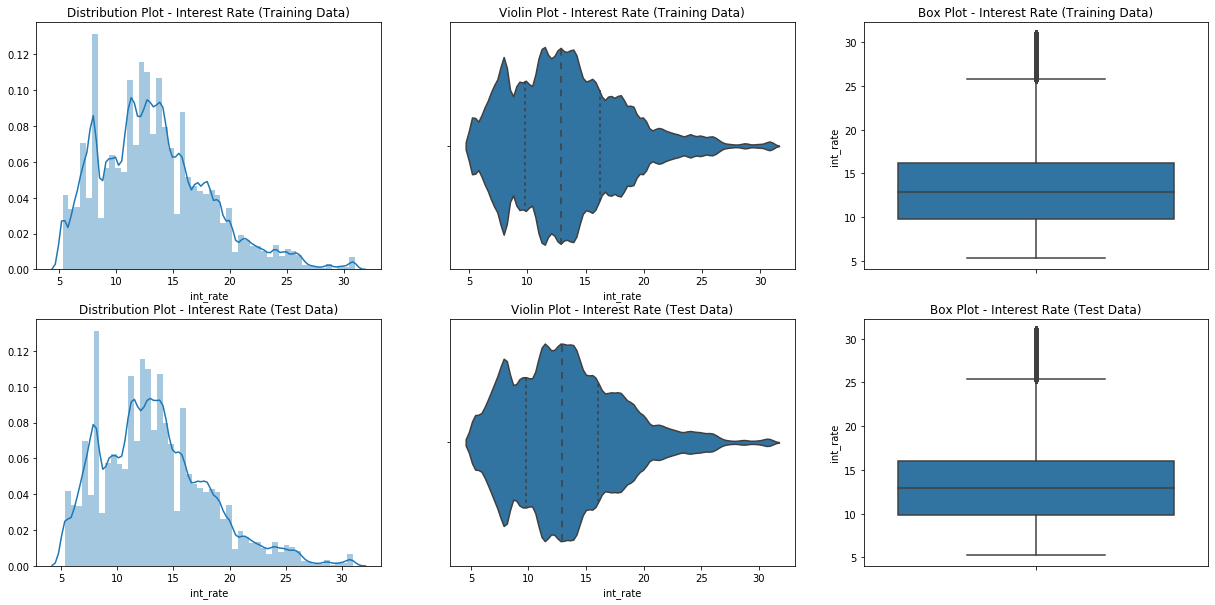

In [952]:
# Plotting for Interest rate, in training dataset
fig, ax = plt.subplots(2,3,figsize=(21,10))
ax[0][0].set_title("Distribution Plot - Interest Rate (Training Data)")
sns.distplot(df_train['int_rate'],ax=ax[0][0])
ax[0][1].set_title("Violin Plot - Interest Rate (Training Data)")
sns.violinplot(data=df_train, x='int_rate',ax=ax[0][1], inner="quartile")
ax[0][2].set_title("Box Plot - Interest Rate (Training Data)")
sns.boxplot(data=df_train, x='int_rate',ax=ax[0][2],orient='v')

# Plottting for Interest Rate, in test dataset
ax[1][0].set_title("Distribution Plot - Interest Rate (Test Data)")
sns.distplot(df_test['int_rate'],ax=ax[1][0])
ax[1][1].set_title("Violin Plot - Interest Rate (Test Data)")
sns.violinplot(data=df_test, x='int_rate',ax=ax[1][1], inner="quartile")
ax[1][2].set_title("Box Plot - Interest Rate (Test Data)")
sns.boxplot(data=df_test, x='int_rate',ax=ax[1][2],orient='v')

# Extract outliers from the boxplot and remove the rows from training dataset
outlier_train_int_rate = boxplot_stats(df_train['int_rate']).pop(0)['fliers']
df_train = df_train[~df_train['int_rate'].isin(outlier_train_int_rate)]
print (df_train.shape)

# Extract outliers from the boxplot and remove the rows from training dataset
outlier_test_int_rate = boxplot_stats(df_test['int_rate']).pop(0)['fliers']
df_test = df_test[~df_test['int_rate'].isin(outlier_test_int_rate)]
print (df_test.shape)

(900334, 94)
(299280, 94)


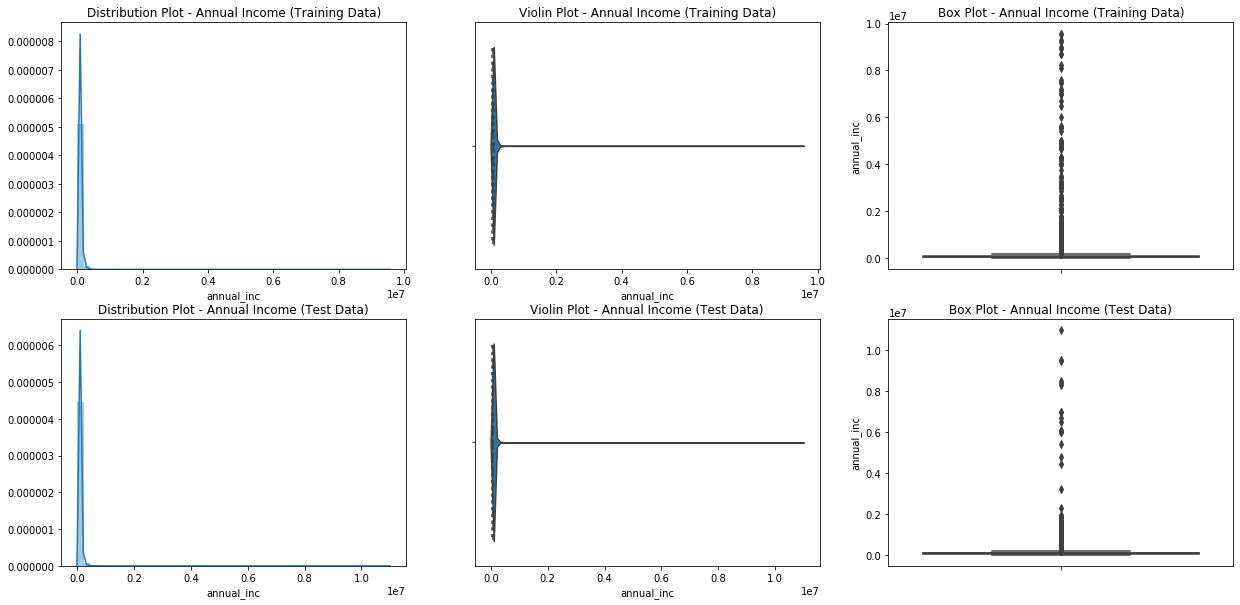

In [953]:
# Optional to run this cell twice, as there are some extreme outliers that need to be removed in the first pass
# Plotting for Annual income, in training dataset
fig, ax = plt.subplots(2,3,figsize=(21,10))
ax[0][0].set_title("Distribution Plot - Annual Income (Training Data)")
sns.distplot(df_train['annual_inc'],ax=ax[0][0])
ax[0][1].set_title("Violin Plot - Annual Income (Training Data)")
sns.violinplot(data=df_train, x='annual_inc',ax=ax[0][1], inner="quartile")
ax[0][2].set_title("Box Plot - Annual Income (Training Data)")
sns.boxplot(data=df_train, x='annual_inc',ax=ax[0][2],orient='v')

# Plottting for Annual Income, in test dataset
ax[1][0].set_title("Distribution Plot - Annual Income (Test Data)")
sns.distplot(df_test['annual_inc'],ax=ax[1][0])
ax[1][1].set_title("Violin Plot - Annual Income (Test Data)")
sns.violinplot(data=df_test, x='annual_inc',ax=ax[1][1], inner="quartile")
ax[1][2].set_title("Box Plot - Annual Income (Test Data)")
sns.boxplot(data=df_test, x='annual_inc',ax=ax[1][2],orient='v')

# Extract outliers from the boxplot and remove the rows from training dataset
outlier_train_annual_inc = boxplot_stats(df_train['annual_inc']).pop(0)['fliers']
df_train = df_train[~df_train['annual_inc'].isin(outlier_train_annual_inc)]
print (df_train.shape)

# Extract outliers from the boxplot and remove the rows from training dataset
outlier_test_annual_inc = boxplot_stats(df_test['annual_inc']).pop(0)['fliers']
df_test = df_test[~df_test['annual_inc'].isin(outlier_test_annual_inc)]
print (df_test.shape)

In [954]:
print (df_train.loan_amnt)
print (df_train.int_rate.describe())
print (df_train.annual_inc.describe())

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Observation (continuous variable)
* After removing the outliers, we can see that most of the loans have loan amount between 8000-20000 USD 
* Most of the loans have interest rate between 5-15% 
* Most of the borrowers have annual income between 45000 to 90000 USD



## Univariate Analysis - Categorical variables
Next we investigate on some of the key categorical variables, namely Loan status, Purpose, Home Ownership, and Term of the loan

Fully Paid           0.7788776165
Charged Off          0.1959283999
Late (31-120 days)   0.0159729611
In Grace Period      0.0064698212
Late (16-30 days)    0.0027345407
Default              0.0000166605
Name: loan_status, dtype: float64
Fully Paid           0.7804230152
Charged Off          0.1948041967
Late (31-120 days)   0.0157010158
In Grace Period      0.0064588345
Late (16-30 days)    0.0025761828
Default              0.0000367549
Name: loan_status, dtype: float64


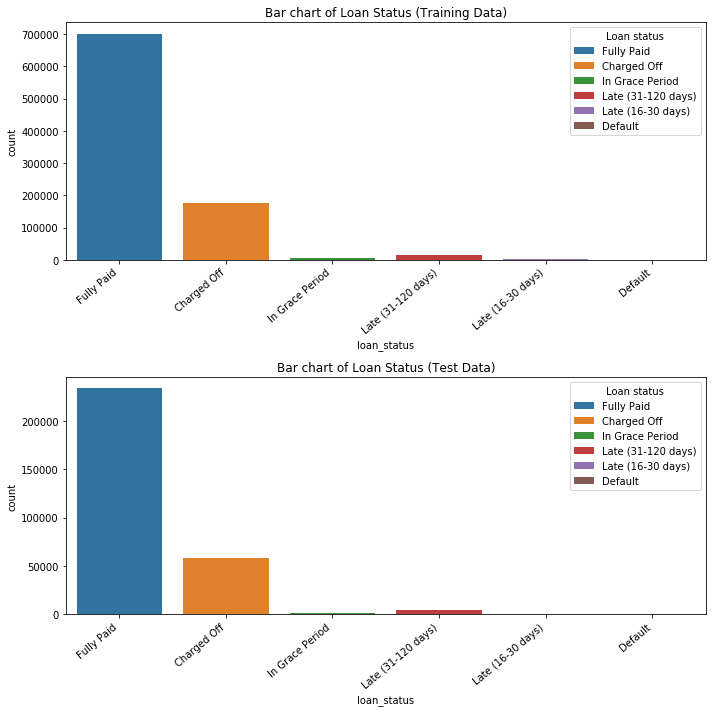

In [955]:
# Plot for Loan Status
print (df_train.loan_status.value_counts(normalize=True))
print (df_test.loan_status.value_counts(normalize=True))
f, ax = plt.subplots(2,1,figsize=(10,10))
labels=["Fully Paid", "Charged Off",  "In Grace Period", "Late (31-120 days)", "Late (16-30 days)", "Default"]

# Plot for Loan Status - training data
sns.countplot(data = df_train, x='loan_status', hue='loan_status', order = labels, hue_order=labels, dodge=False ,ax=ax[0])
h,l = ax[0].get_legend_handles_labels()
ax[0].legend(h,labels,title="Loan status", loc="upper right") 
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha="right")
ax[0].set_title("Bar chart of Loan Status (Training Data)")

# Plot for Loan Status - test data
sns.countplot(data = df_test, x='loan_status', hue='loan_status', order = labels, hue_order=labels, dodge=False ,ax=ax[1])
h,l = ax[1].get_legend_handles_labels()
ax[1].legend(h,labels,title="Loan status", loc="upper right") 
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha="right")
ax[1].set_title("Bar chart of Loan Status (Test Data)")

plt.tight_layout()
plt.show()

### Observation - Loan Status
* Without considering loans that are "Current", the dataset is still quite imbalanced. Majority of the loans are fully paid, and bad loans account for a relatively small percentage of the total loans (20%-30%)

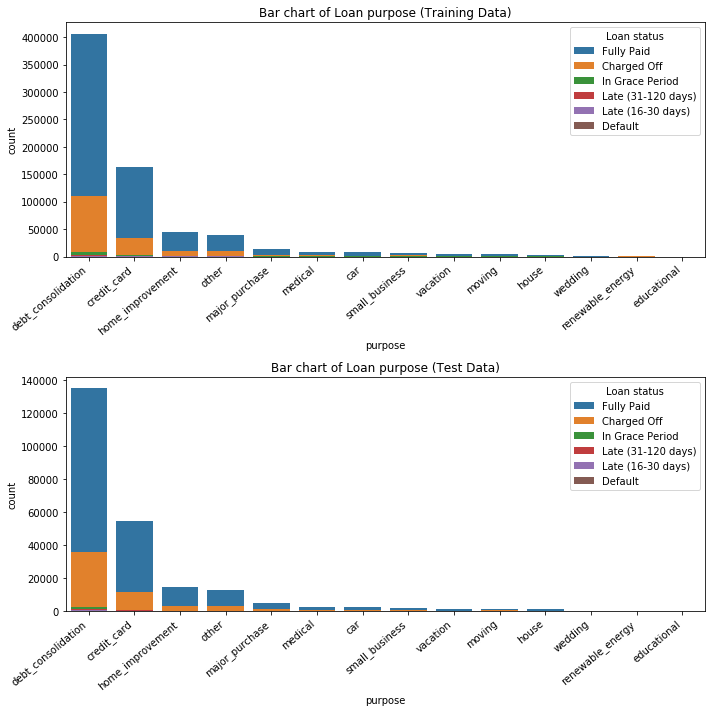

(900333, 94)
(299280, 94)


In [956]:
# Plot for Loan purpose
# print (df_train.purpose.value_counts(normalize=True))
# print (df_test.purpose.value_counts(normalize=True))
f, ax = plt.subplots(2,1,figsize=(10,10))
labels = list(df_train.purpose.value_counts().index)
labels_status=["Fully Paid", "Charged Off",  "In Grace Period", "Late (31-120 days)", "Late (16-30 days)", "Default"]

# Plot for Loan purpose - training data
# print (df_train.purpose.value_counts(normalize=True))
sns.countplot(data = df_train, x='purpose', hue='loan_status', order = labels, dodge=False ,ax=ax[0])
h,l = ax[0].get_legend_handles_labels()
ax[0].legend(h,labels_status,title="Loan status", loc="upper right") 
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha="right")
ax[0].set_title("Bar chart of Loan purpose (Training Data)")

# Plot for Loan Status - test data
# print (df_test.purpose.value_counts(normalize=True))
sns.countplot(data = df_test, x='purpose', hue='loan_status', order = labels, dodge=False ,ax=ax[1])
h,l = ax[1].get_legend_handles_labels()
ax[1].legend(h,labels_status,title="Loan status", loc="upper right") 
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha="right")
ax[1].set_title("Bar chart of Loan purpose (Test Data)")

plt.tight_layout()
plt.show()

# Remove loans that are for "educational" purpose as they are not very representative of the larger dataset
df_train = df_train[df_train['purpose']!='educational']
df_test = df_test[df_test['purpose']!='educational']
print (df_train.shape)
print (df_test.shape)

### Observation - Purpose
* Close to 60% of the loans are applied for debt consolidation purpose, i.e. to repay other debt.
* Some of the loan purposes account for a minimal percentage, e.g. educational. These can be removed. 

(900078, 94)
(299189, 94)


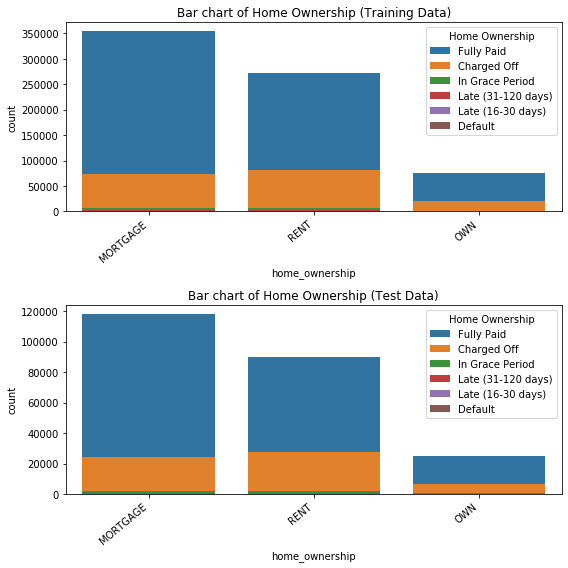

In [957]:
# Plot for Home ownership column
# print (df_train.home_ownership.value_counts(normalize=True))
# print (df_test.home_ownership.value_counts(normalize=True))
# Remove rows that are a very small proportion of the total loans
to_remove = ['ANY','NONE','OTHER']
df_train = df_train[~df_train.home_ownership.isin(to_remove)]
df_test = df_test[~df_test.home_ownership.isin(to_remove)]
print (df_train.shape)
print (df_test.shape)

f, ax = plt.subplots(2,1,figsize=(8,8))
labels = list(df_train.home_ownership.value_counts().index)
labels_status=["Fully Paid", "Charged Off",  "In Grace Period", "Late (31-120 days)", "Late (16-30 days)", "Default"]

# Plot for Loan purpose - training data
# print (df_train.purpose.value_counts(normalize=True))
sns.countplot(data = df_train, x='home_ownership', hue='loan_status', order = labels, dodge=False ,ax=ax[0])
h,l = ax[0].get_legend_handles_labels()
ax[0].legend(h,labels_status,title="Home Ownership", loc="upper right") 
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha="right")
ax[0].set_title("Bar chart of Home Ownership (Training Data)")

# Plot for Loan Status - test data
# print (df_test.purpose.value_counts(normalize=True))
sns.countplot(data = df_test, x='home_ownership', hue='loan_status', order = labels, dodge=False ,ax=ax[1])
h,l = ax[1].get_legend_handles_labels()
ax[1].legend(h,labels_status,title="Home Ownership", loc="upper right") 
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha="right")
ax[1].set_title("Bar chart of Home Ownership (Test Data)")

plt.tight_layout()
plt.show()

### Observation - Homeownership
* Majority of the loans are registered with these home ownership status: _['MORTGAGE','RENT','OWN']_. Hence we will remove rows with the rest of the statuses

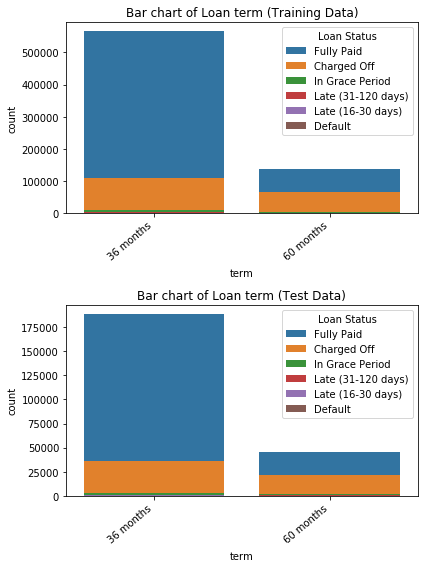

In [958]:
# Plot for Loan Term
f, ax = plt.subplots(2,1,figsize=(6,8))
labels = list(df_train.term.value_counts().index)
labels_status=["Fully Paid", "Charged Off",  "In Grace Period", "Late (31-120 days)", "Late (16-30 days)", "Default"]

# Plot for Loan Term - training data
sns.countplot(data = df_train, x='term', hue='loan_status', order = labels, dodge=False ,ax=ax[0])
h,l = ax[0].get_legend_handles_labels()
ax[0].legend(h,labels_status,title="Loan Status", loc="upper right") 
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha="right")
ax[0].set_title("Bar chart of Loan term (Training Data)")

# Plot for Loan Term - test data
sns.countplot(data = df_test, x='term', hue='loan_status', order = labels, dodge=False ,ax=ax[1])
h,l = ax[1].get_legend_handles_labels()
ax[1].legend(h,labels_status,title="Loan Status", loc="upper right") 
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha="right")
ax[1].set_title("Bar chart of Loan term (Test Data)")

plt.tight_layout()
plt.show()

### Observation - Term
* We can see that loans with a longer term (i.e. 60 months) are more likely to be bad loan

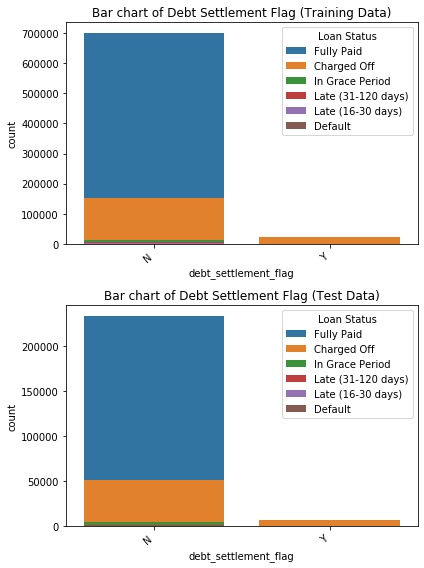

In [959]:
# Plot for Debt Settlement Flag, which indicates whether or not the borrower, who has charged off, is working with a debt-settlement company
f, ax = plt.subplots(2,1,figsize=(6,8))
labels = list(df_train.debt_settlement_flag.value_counts().index)
labels_status=["Fully Paid", "Charged Off",  "In Grace Period", "Late (31-120 days)", "Late (16-30 days)", "Default"]

# Plot for Debt Settlement Flag - training data
sns.countplot(data = df_train, x='debt_settlement_flag', hue='loan_status', order = labels, dodge=False ,ax=ax[0])
h,l = ax[0].get_legend_handles_labels()
ax[0].legend(h,labels_status,title="Loan Status", loc="upper right") 
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha="right")
ax[0].set_title("Bar chart of Debt Settlement Flag (Training Data)")

# Plot for Debt Settlement Flag - test data
sns.countplot(data = df_test, x='debt_settlement_flag', hue='loan_status', order = labels, dodge=False ,ax=ax[1])
h,l = ax[1].get_legend_handles_labels()
ax[1].legend(h,labels_status,title="Loan Status", loc="upper right") 
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha="right")
ax[1].set_title("Bar chart of Debt Settlement Flag (Test Data)")

plt.tight_layout()
plt.show()

### Observation - Debt Settlement Flag
* From a business perspective, the debt settlement flag only applies if a loan has already been charged off.
* Therefore, this flag is an outcome of the loan status, and hence we should not use it for determining a bad loan.

In [960]:
df_train.drop(columns='debt_settlement_flag',inplace=True)
df_test.drop(columns='debt_settlement_flag',inplace=True)
print (df_train.shape)
print (df_test.shape)

(900078, 93)
(299189, 93)


### Observation - Payment Plan
* Another similar column is _pymnt_plan_ , from a business perspective, payment plan only applies if the loan is late, which indicates it is bad loan. Hence, we should not use _pymnt_plan_ for our prediction. 

In [961]:
print (df_train[df_train.pymnt_plan=='y']['loan_status'].value_counts())
print (df_test[df_test.pymnt_plan=='y']['loan_status'].value_counts())
df_train.drop(columns='pymnt_plan',inplace=True)
df_test.drop(columns='pymnt_plan',inplace=True)
print (df_train.shape)
print (df_test.shape)

Late (31-120 days)    430
Late (16-30 days)       7
In Grace Period         2
Name: loan_status, dtype: int64
Late (31-120 days)    142
Late (16-30 days)       2
In Grace Period         1
Name: loan_status, dtype: int64
(900078, 92)
(299189, 92)


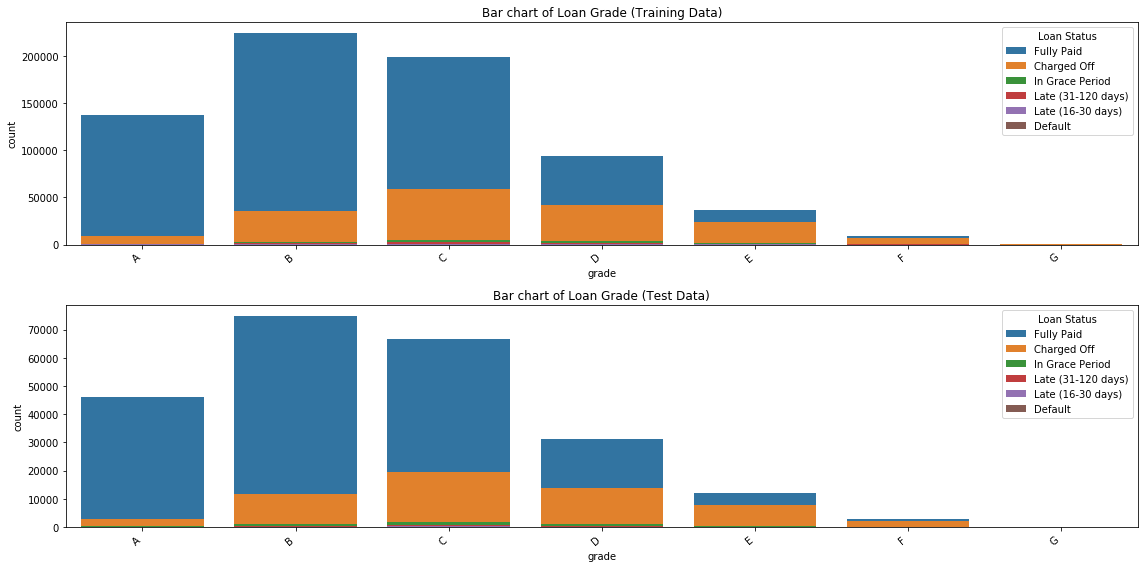

In [962]:
# Plot for Grade
f, ax = plt.subplots(2,1,figsize=(16,8))
labels = ['A','B','C','D','E','F','G']
labels_status=["Fully Paid", "Charged Off",  "In Grace Period", "Late (31-120 days)", "Late (16-30 days)", "Default"]

# Plot for Loan Grade - training data
sns.countplot(data = df_train, x='grade', hue='loan_status', order = labels, dodge=False ,ax=ax[0])
h,l = ax[0].get_legend_handles_labels()
ax[0].legend(h,labels_status,title="Loan Status", loc="upper right") 
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha="right")
ax[0].set_title("Bar chart of Loan Grade (Training Data)")

# Plot for Loan Grade - test data
sns.countplot(data = df_test, x='grade', hue='loan_status', order = labels, dodge=False ,ax=ax[1])
h,l = ax[1].get_legend_handles_labels()
ax[1].legend(h,labels_status,title="Loan Status", loc="upper right") 
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha="right")
ax[1].set_title("Bar chart of Loan Grade (Test Data)")

plt.tight_layout()
plt.show()

### Observation - Grade
* It would be common sense that the lower the grade the loan is, the higher the chance that it is a bad loan. This is indeed the case in above plot. 
* However, this raises the question whether _grade_ can be used a column for prediction, since this is the grade assigned by Lending Club itself, based on their prediction of the loan

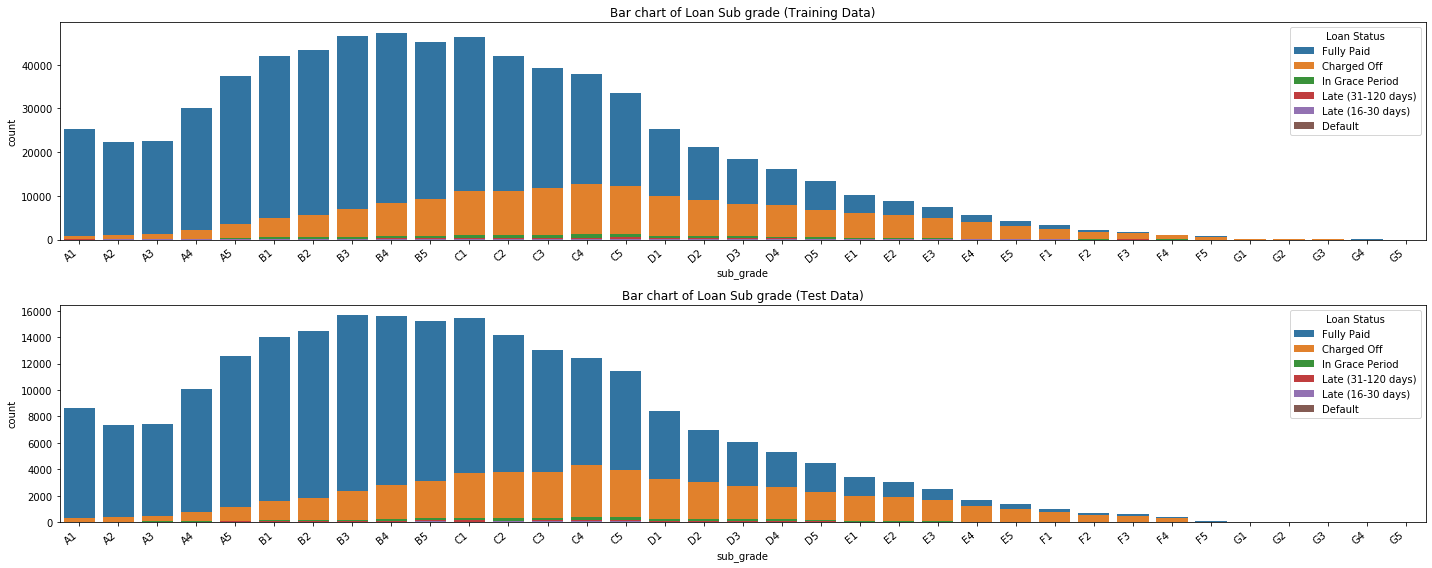

In [963]:
# Plot for Sub grade
f, ax = plt.subplots(2,1,figsize=(20,8))
labels = ['A1','A2','A3','A4','A5','B1','B2','B3','B4','B5','C1','C2','C3','C4','C5',\
          'D1','D2','D3','D4','D5','E1','E2','E3','E4','E5','F1','F2','F3','F4','F5','G1','G2','G3','G4','G5']
labels_status=["Fully Paid", "Charged Off",  "In Grace Period", "Late (31-120 days)", "Late (16-30 days)", "Default"]

# Plot for Loan Grade - training data
sns.countplot(data = df_train, x='sub_grade', hue='loan_status', order = labels, dodge=False ,ax=ax[0])
h,l = ax[0].get_legend_handles_labels()
ax[0].legend(h,labels_status,title="Loan Status", loc="upper right") 
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha="right")
ax[0].set_title("Bar chart of Loan Sub grade (Training Data)")

# Plot for Loan Grade - test data
sns.countplot(data = df_test, x='sub_grade', hue='loan_status', order = labels, dodge=False ,ax=ax[1])
h,l = ax[1].get_legend_handles_labels()
ax[1].legend(h,labels_status,title="Loan Status", loc="upper right") 
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha="right")
ax[1].set_title("Bar chart of Loan Sub grade (Test Data)")

plt.tight_layout()
plt.show()

### Observation - Sub Grade
* Similar to grade, we can see that the lower the sub-grade assigned by Lending Club, the higher the proportions of loans identified as bad loans. 
* We will think about whether to keep both Grade & Sub grade for prediction purpose.

## Bivariate/Multivariate Analysis
Next, we will perform some analysis between variables, to investigate their relationship, for further findings before prediction. The analysis will be done on both the training and the test dataset.

For example, in below analysis, we try to investigate relationship between __categorical variables__, such as _Loan Purpose, Employment Length, Loan Status_ and __continuous variable__ - _Loan Amount_

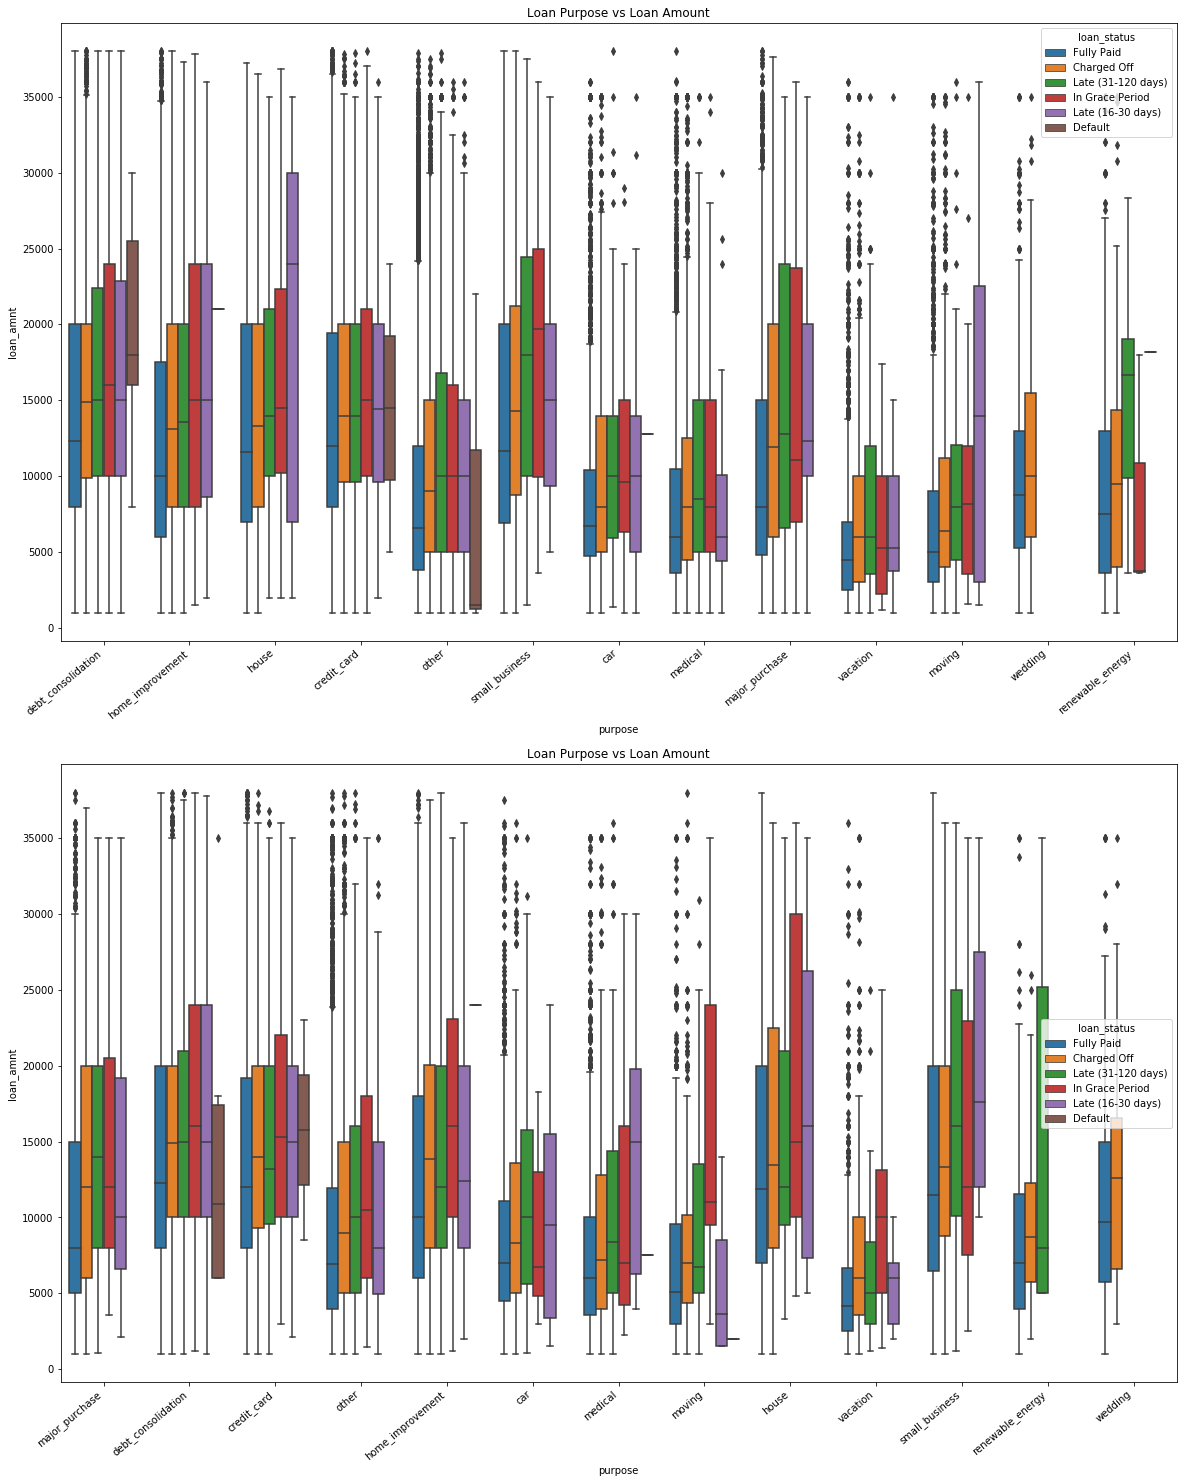

In [964]:
# Analysis and Purpose of the loan v.s. Loan amount
f, ax = plt.subplots(2,1,figsize=(20,25))

# Plot for training dataset
sns.boxplot(data=df_train, x='purpose', y='loan_amnt', hue ='loan_status',ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha="right")
ax[0].set_title('Loan Purpose vs Loan Amount')

# Plot for test dataset
sns.boxplot(data=df_test, x='purpose', y='loan_amnt', hue ='loan_status',ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha="right")
ax[1].set_title('Loan Purpose vs Loan Amount')
plt.show()

### Observation
* From above plot, we can see that some of the common purposes that give rise to high loan amount are: _debt_consolidation, house, and small_business_
* Most of the Loan defaults happens for loan purposes such as _credit_card, debt_consolidation & other_

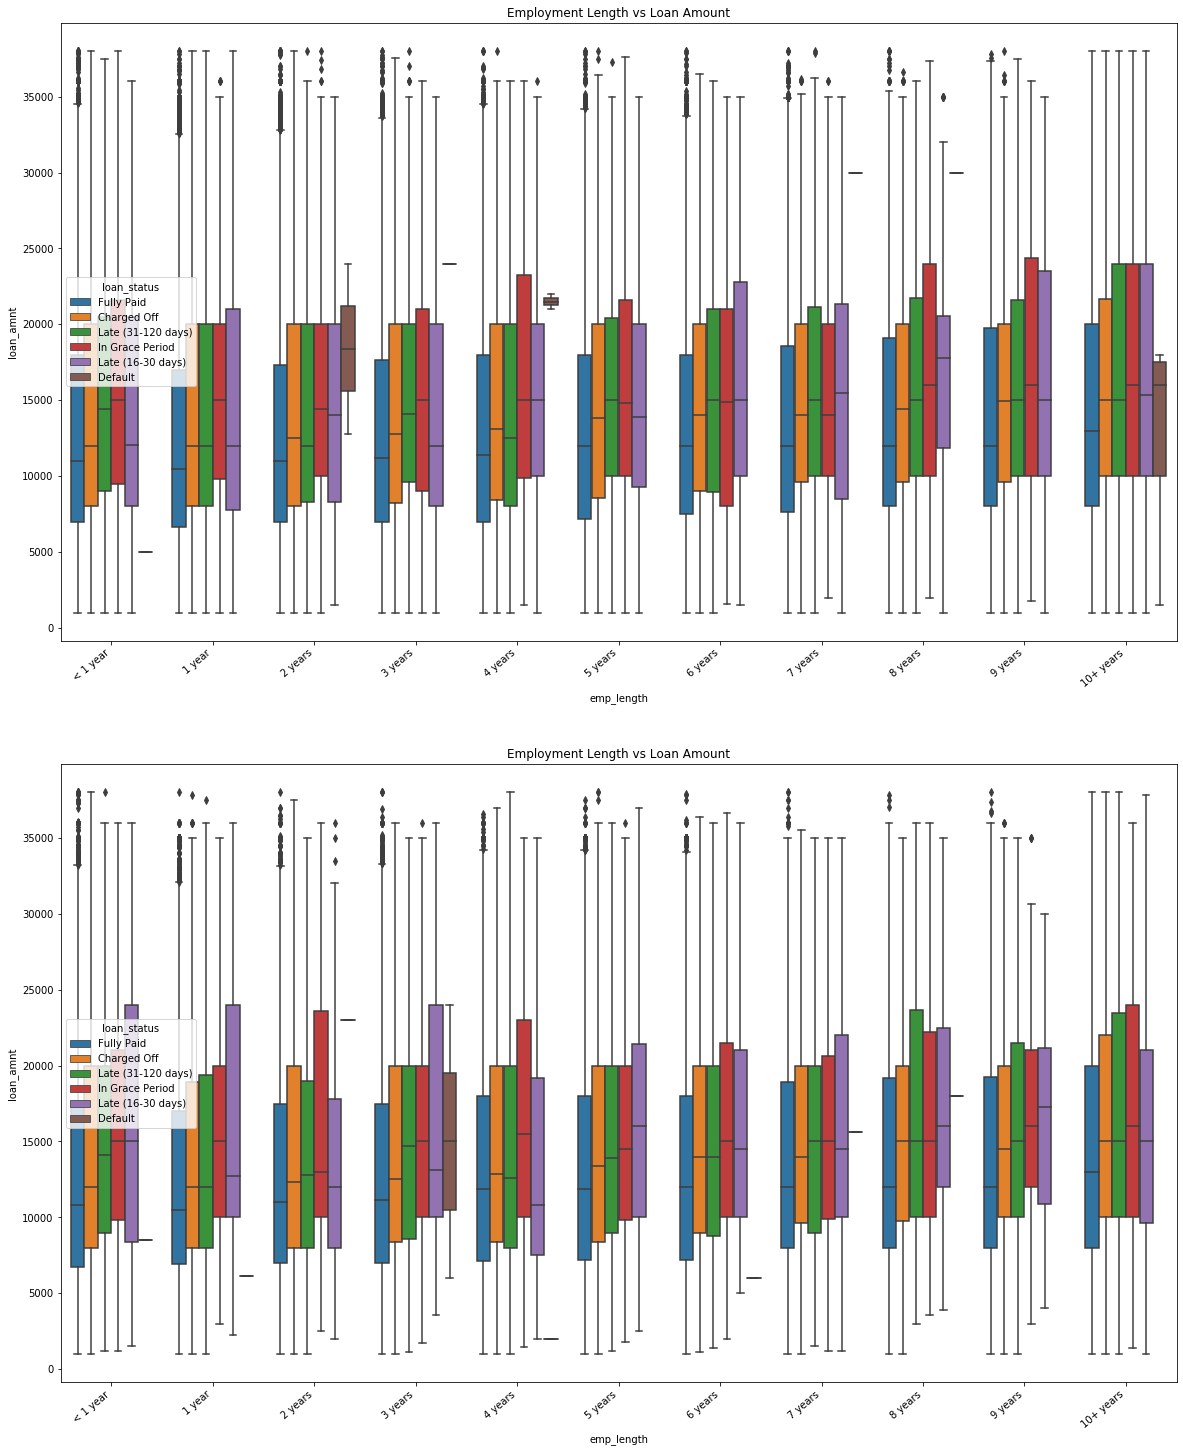

In [965]:
# Remove redundant emp_length_int column, created in section 1 for plotting graphs
df_train.drop(columns='emp_length_int',inplace=True)
df_test.drop(columns='emp_length_int',inplace=True)

# Analysis and Employment Length v.s. Loan amount
f, ax = plt.subplots(2,1,figsize=(20,25))
labels = ['< 1 year','1 year','2 years','3 years','4 years','5 years','6 years','7 years','8 years','9 years','10+ years']

# Plot for training dataset
sns.boxplot(data=df_train, x='emp_length', y='loan_amnt', order=labels, hue ='loan_status',ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha="right")
ax[0].set_title('Employment Length vs Loan Amount')

# Plot for test dataset
sns.boxplot(data=df_test, x='emp_length', y='loan_amnt', order=labels, hue ='loan_status',ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha="right")
ax[1].set_title('Employment Length vs Loan Amount')
plt.show()

### Observation
* We would have thought the lesser number of years employed, the more likely the borrower will apply for loans with larger amount. This is not necessarily the case except there are more outliers with exceptional large loan amounts.
* In terms of the risk, we can see that borrowers with less employment length are not necessarily mean more risks of the loan. We can see the proportion of loans fully paid to be about the same amongst various employment lengths.

Next, we try to investigate the __correlation between continuous variables__ in the dataset. If two or more variables are high correlated, we should just keep one of the variables during training and prediction

In [966]:
train_corr = df_train.corr()
train_corr

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,issue_y,issue_m,loan_to_income_ratio
loan_amnt,1.0000000000,0.9999856504,0.9999774025,0.1436915837,0.9518157253,0.4586744804,0.0529787789,-0.0069095735,-0.0233106736,0.1737198023,...,0.0342401442,-0.0966710913,-0.0025751238,0.2989716016,0.2431957193,0.3473902442,0.1645244067,-0.0218438105,-0.0215870011,0.0038035987
funded_amnt,0.9999856504,1.0000000000,0.9999918634,0.1436692241,0.9518294094,0.4586722495,0.0529800183,-0.0069059623,-0.0233177015,0.1737195374,...,0.0342370211,-0.0966644964,-0.0025719962,0.2989717338,0.2431965442,0.3473996958,0.1645244554,-0.0217893412,-0.0215905574,0.0038036983
funded_amnt_inv,0.9999774025,0.9999918634,1.0000000000,0.1436642874,0.9517882499,0.4587056311,0.0529316050,-0.0069105485,-0.0233035018,0.1737199885,...,0.0341810696,-0.0966453818,-0.0025779305,0.2989926782,0.2431969848,0.3474240400,0.1645257123,-0.0215788777,-0.0216486575,0.0038005614
int_rate,0.1436915837,0.1436692241,0.1436642874,1.0000000000,0.1472711904,-0.1158501765,0.1368615841,0.0446458169,0.2167940151,-0.0095037278,...,0.2632323981,0.0514081865,0.0107205868,-0.1184266632,0.0154564612,-0.2370990559,0.0017420321,-0.0649364131,0.0038285972,-0.0003036205
installment,0.9518157253,0.9518294094,0.9517882499,0.1472711904,1.0000000000,0.4340494844,0.0550352338,0.0017971426,-0.0005947313,0.1619329197,...,0.0536135119,-0.0898643750,0.0033496333,0.2599756227,0.2235834003,0.3130943476,0.1467575706,-0.0244705794,-0.0236866556,0.0037738195
annual_inc,0.4586744804,0.4586722495,0.4587056311,-0.1158501765,0.4340494844,1.0000000000,-0.1632163205,0.0653720645,0.0449437896,0.2120266550,...,-0.0097593650,-0.0612485854,0.0317669751,0.5068008944,0.3746130123,0.3321155978,0.3346489216,0.0282414618,-0.0094438010,-0.0056525955
dti,0.0529787789,0.0529800183,0.0529316050,0.1368615841,0.0550352338,-0.1632163205,1.0000000000,-0.0061308697,-0.0016430645,0.2285062626,...,0.1245318874,-0.0258241387,-0.0180273144,0.0546636415,0.2755873399,0.0521522592,0.2929419842,0.0442720800,-0.0024348841,0.2609708738
delinq_2yrs,-0.0069095735,-0.0069059623,-0.0069105485,0.0446458169,0.0017971426,0.0653720645,-0.0061308697,1.0000000000,0.0253764371,0.0514817003,...,-0.0104822875,-0.0490472343,0.0082436609,0.0632040299,0.0322535910,-0.0771739361,0.0628841628,0.0155589811,0.0035945510,-0.0007219184
inq_last_6mths,-0.0233106736,-0.0233177015,-0.0233035018,0.2167940151,-0.0005947313,0.0449437896,-0.0016430645,0.0253764371,1.0000000000,0.1366225855,...,-0.0673582404,0.0803440377,0.0095484849,0.0259647688,0.0322036299,-0.0101898651,0.0401999191,-0.0837755509,-0.0015238839,-0.0003469384
open_acc,0.1737198023,0.1737195374,0.1737199885,-0.0095037278,0.1619329197,0.2120266550,0.2285062626,0.0514817003,0.1366225855,1.0000000000,...,-0.0983478351,-0.0239126524,-0.0064143311,0.2858689658,0.4112932017,0.3559694403,0.3581262918,0.0215906828,-0.0096949512,0.0020729908


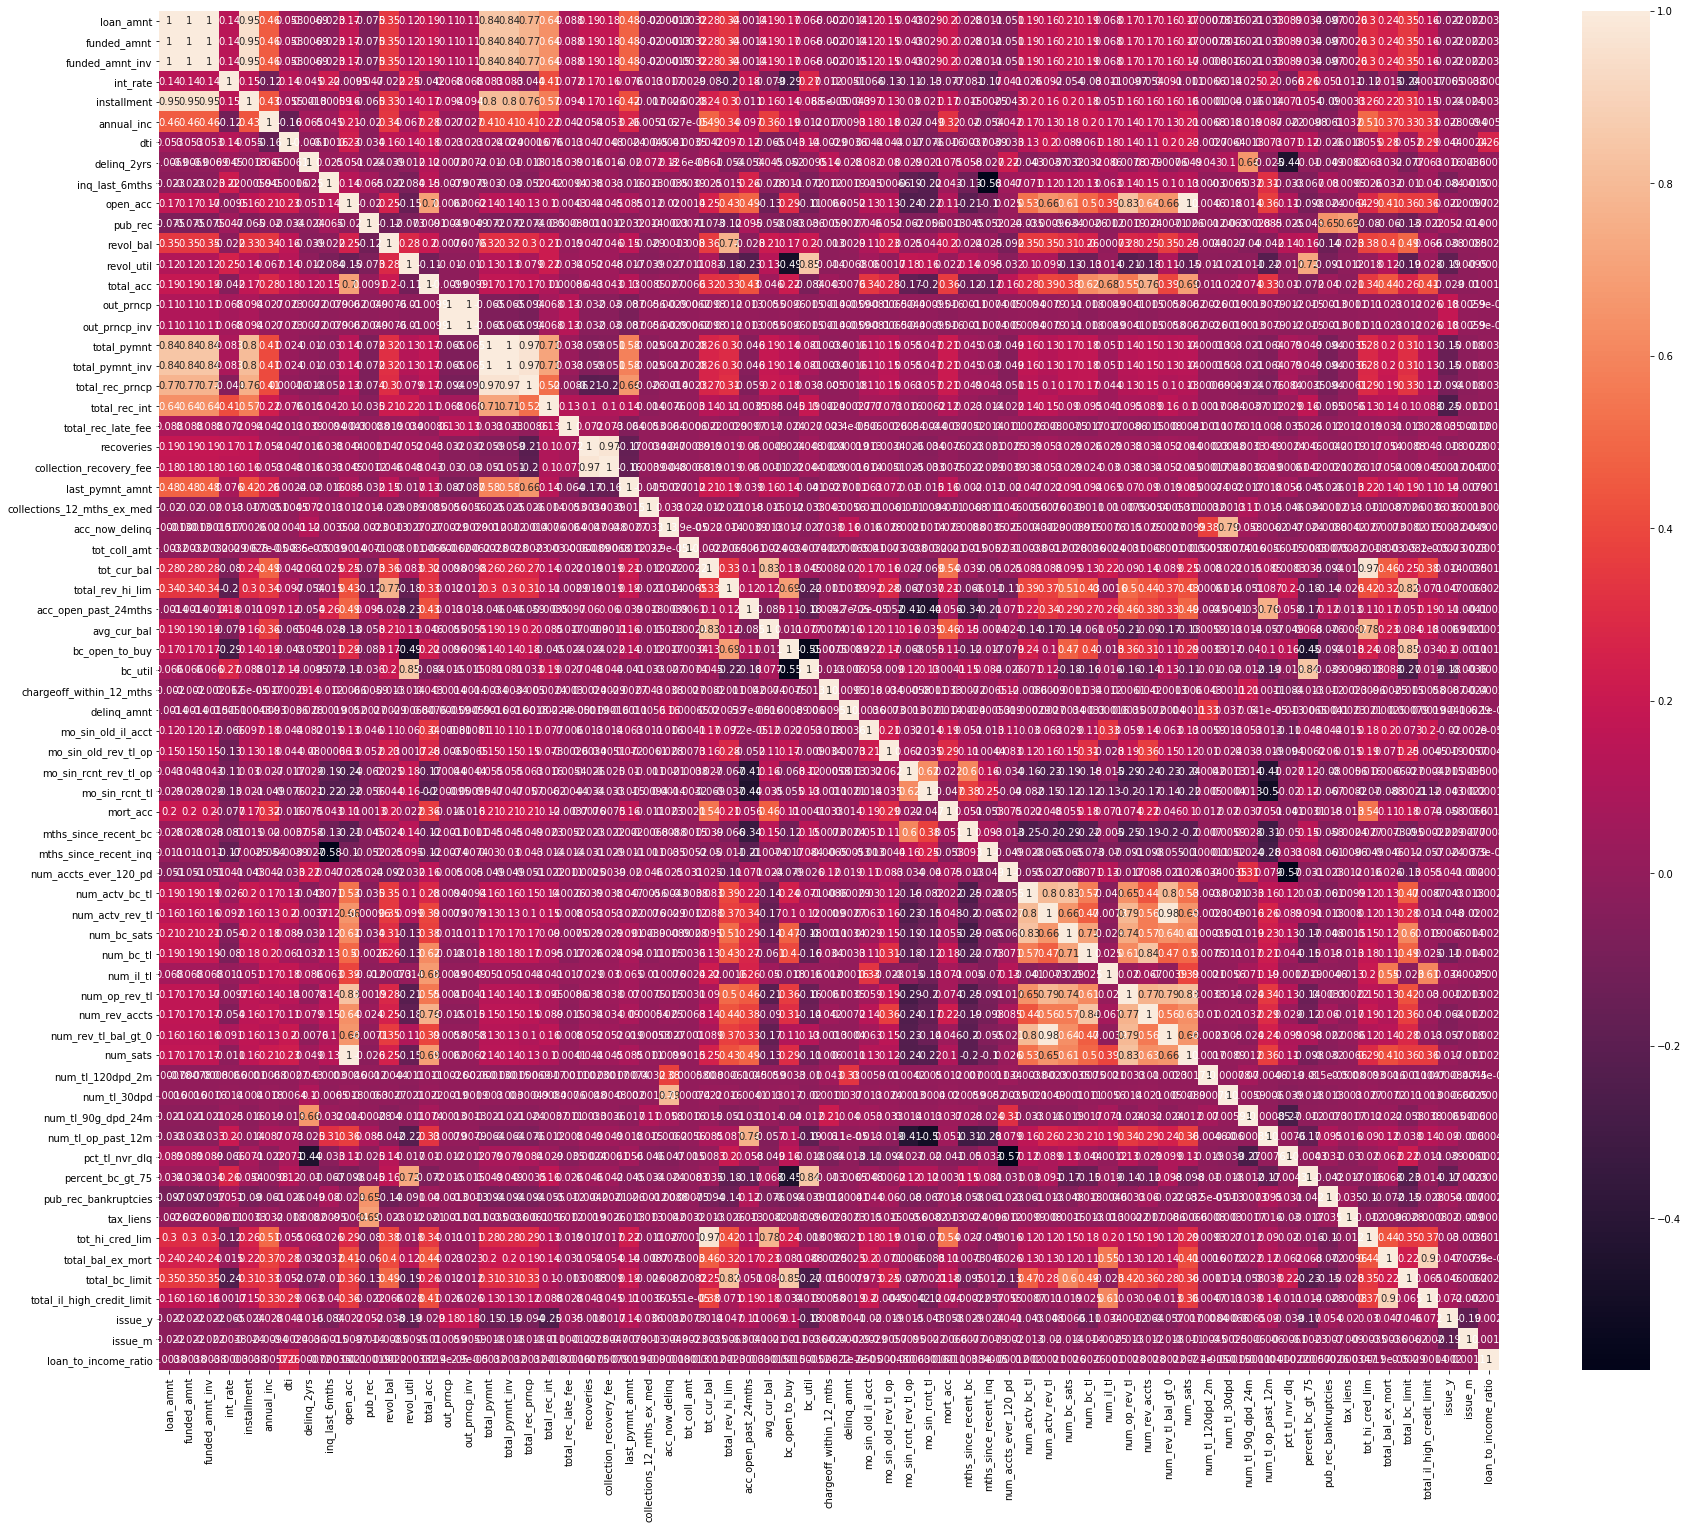

In [967]:
f, ax = plt.subplots(figsize=(30, 25))
sns.heatmap(train_corr, 
            xticklabels=train_corr.columns.values,
            yticklabels=train_corr.columns.values,annot= True)
plt.show()

### Observation
We inspect which columns have correlation score of >=0.90 or <= -0.90, and remove the redundant columns, for both training and test set.
* As we have previously suspected, _[loan_amnt, funded_amnt, funded_amnt_inv]_ are highly correlated. We can thus keep __loan_amnt__ only, for our prediction model
* Similarly, _[total_pymnt, total_pymnt, total_rec_int]_ are highly correlated, as all these indicate the total payment received to date. Hence, we can keep __total_pymnt__ column only. 
* _[num_sats, open_acc]_ are also perfectly correlated as both indicate the number of accounts already opened by the borrower. We can thus keep __open_acc__ only.
* _[tot_cur_bal, tot_hi_cred_lim]_ are highly correlated as both indicate the total credit limit / current balance of the borrower. We will keep __total_cur_bal__, for our prediction purpose
* _[num_actv_rev_tl, num_rev_tl_bal_gt_0]_ are both linked to the number of revolving trade, and highly correlated. We will ony keep __num_actv_rev_tl__ in this case.
* _[out_prncp, out_prncp_inv]_ are both related to remaining outstanding principal amounts. Since they are highly correlated, we will just keep __out_prncp__ for prediction purpose
* _[recoveries, collection_recovery_fee]_ are both related to recoveries post charge-off. Upon checking the data dictionary, we have decided to remove both columns as they are outcomes of a loan charge-off
* _[total_pymnt_inv, total_rec_prncp]_ are highly correlated (0.97), as both are related to the total principal amount. Hence, we will keep __total_rec_prncp__
* _[installment, loan_amnt]_ are highly correlated (0.95). Hence, we will remove installment, and keep __loan_amnt__.
* _[total_bal_ex_mort, total_il_high_credit_limit]_ are highly correlated as both are tied to the remaining credit balance. We will keep __total_il_high_credit_limit__

In [968]:
redundant_cols = ['funded_amnt', 'funded_amnt_inv', 'total_pymnt', \
                  'total_rec_int', 'num_sats', 'tot_hi_cred_lim','num_rev_tl_bal_gt_0',\
                  'out_prncp_inv','recoveries','collection_recovery_fee',\
                  'total_pymnt_inv','installment','total_bal_ex_mort']
df_train.drop(columns=redundant_cols, inplace=True)
df_test.drop(columns=redundant_cols, inplace=True)

print (df_train.shape)
print (df_test.shape)

(900078, 78)
(299189, 78)


## Keep only useful columns for prediction
Now, we still have a lot of columns left, some of which might not necessarily have an impact when predicting whether the loan is a good / bad loan. 

For this, we checked each column and its definition in the accompanying Data Dictionary (LCDataDictionary.xlsx). Based on the previous exploratory analysis and our judgement, we select only a handful of columns to keep for our prediction problem.

In [969]:
# # Load the accomanying data dictionary with column description
# df_description = pd.read_excel('data/LCDataDictionary.xlsx').dropna()
# df_description.style.set_properties(subset=['Description'], **{'width': '1000px'})
cols_to_keep = ['loan_amnt','annual_inc','int_rate','term','grade','sub_grade','emp_length','home_ownership','verification_status',\
                'issue_d','loan_status','purpose','addr_state','dti','delinq_2yrs','earliest_cr_line',\
                'open_acc','pub_rec','revol_util','out_prncp','total_rec_late_fee','last_pymnt_d','last_credit_pull_d',\
                'collections_12_mths_ex_med','application_type','acc_now_delinq','tot_coll_amt','total_rev_hi_lim',\
                'acc_open_past_24mths','bc_util','chargeoff_within_12_mths','delinq_amnt','mort_acc','num_accts_ever_120_pd',\
                'num_actv_bc_tl','num_actv_rev_tl','num_tl_120dpd_2m','num_tl_30dpd','num_tl_90g_dpd_24m','pct_tl_nvr_dlq',\
                'pub_rec_bankruptcies','tax_liens','total_il_high_credit_limit','hardship_flag','disbursement_method',\
                'region','loan_condition','loan_to_income_ratio','emp_title','title']
df_train = df_train[cols_to_keep]
df_test = df_test[cols_to_keep]
print (df_train.shape)
print (df_test.shape)

(900078, 50)
(299189, 50)


For categorical variables, we are not able to plot the correlation. However, we can check how many unique values are there for each variable. 
* If there are too many unique values, it might not make sense to use that column for prediction, e.g. emp_title, title. 
* If there are only 2 unique values, then we can label encode the column for prediction
* If there are more than 2 unique values, we need to perform one-hot encoding on the column

In [970]:
print (df_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0))
df_train.drop(columns=['emp_title','title'],inplace=True)
df_test.drop(columns=['emp_title','title'],inplace=True)

term                        2
grade                       7
sub_grade                  35
emp_length                 12
home_ownership              3
verification_status         3
issue_d                    82
loan_status                 6
purpose                    13
addr_state                 51
earliest_cr_line          725
last_pymnt_d               82
last_credit_pull_d         84
application_type            2
hardship_flag               2
disbursement_method         2
region                      5
loan_condition              2
emp_title              263788
title                   33375
dtype: int64


Some of these categorical variables are actually dates, so we convert them into datetime format. 
* Also, for all continuous variabbles, we will fill the null values with the medians.
* For date variables, we will fill the na columns with '2018-12-01', which is the last day of our dataset

In [971]:
df_test.info(null_counts=True, verbose=True)
# df_test['ref_date'] = pd.to_datetime('2018-12-01', format='%Y-%m-%d')
# print ((df_test.ref_date - df_test.earliest_cr_line ).dt.months.head())
df_test.earliest_cr_line.value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299189 entries, 733217 to 1212382
Data columns (total 48 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   loan_amnt                   299189 non-null  int64  
 1   annual_inc                  299189 non-null  float64
 2   int_rate                    299189 non-null  float64
 3   term                        299189 non-null  object 
 4   grade                       299189 non-null  object 
 5   sub_grade                   299189 non-null  object 
 6   emp_length                  299189 non-null  object 
 7   home_ownership              299189 non-null  object 
 8   verification_status         299189 non-null  object 
 9   issue_d                     299189 non-null  object 
 10  loan_status                 299189 non-null  object 
 11  purpose                     299189 non-null  object 
 12  addr_state                  299189 non-null  object 
 13  dti     

Aug-2001    2115
Sep-2002    2098
Sep-2003    2065
Oct-2001    2064
Aug-2002    2048
Sep-2004    2016
Aug-2000    2011
Aug-2003    1967
Oct-2003    1943
Oct-2002    1901
Oct-2000    1885
Aug-2004    1873
Sep-2000    1853
Nov-1999    1805
Sep-2001    1795
Jul-2003    1781
Oct-2004    1751
Sep-2005    1747
Nov-2001    1714
Aug-2005    1709
Nov-2000    1699
Jul-2001    1695
Aug-2006    1685
Jul-2002    1685
Oct-1999    1682
Mar-2001    1668
Dec-2001    1664
Aug-1999    1643
Sep-1999    1631
May-2001    1591
Jul-2004    1587
Dec-2000    1582
Nov-2002    1568
Dec-2002    1563
May-2003    1549
Sep-1998    1545
May-2002    1545
Mar-2000    1539
Nov-2004    1536
Jun-2003    1526
Apr-2002    1525
Apr-2001    1518
Nov-2003    1518
Mar-2004    1509
Jun-2001    1504
Mar-2002    1499
Dec-2003    1492
Dec-1999    1490
Oct-2005    1485
Jun-2005    1479
Jul-2000    1477
Jun-2004    1469
Dec-2004    1462
Jan-2002    1454
May-2000    1454
Jun-2000    1453
May-2004    1452
Sep-2006    1446
Mar-2005    14

In [972]:
# For Datetime columns, we perform the follow:
# 1 - convert it into python datetime format
# 2 - fill the na values with the median, this applies to all columns with null values
# 3 - calculate the # months elapsed from the date to 2018-12-01

# def month_delta(dt):
#     ref = pd.to_datetime('2018-12-01', format='%Y-%m-%d')
#     return ((df - ref).days)

def col_to_datetime(df, col):
    return pd.to_datetime(df[col], format='%b-%Y', errors='coerce')

    
date_cols = ['issue_d','earliest_cr_line','last_pymnt_d','last_credit_pull_d']#,]

for col in date_cols:
    df_train[col] = col_to_datetime(df_train, col)
    df_test[col] = col_to_datetime(df_test, col)
    print ("%s converted to datetime"%col)

df_train.fillna(df_train.median(),inplace=True)
df_test.fillna(df_test.median(),inplace=True)    
print ("fill na completed")

df_train['ref_date'] = pd.to_datetime('2018-12-01', format='%Y-%m-%d')
df_test['ref_date'] = pd.to_datetime('2018-12-01', format='%Y-%m-%d')

for col in date_cols:
    df_train[col] = (df_train['ref_date']- df_train[col]).dt.days/30
    df_test[col] = (df_test['ref_date']-df_test[col]).dt.days/30
    print ("%s calculated in # month"%col)

df_train.drop(columns='ref_date')
df_test.drop(columns='ref_date')
# # df_train['issue_d'] = pd.to_datetime(df_train['issue_d'], format='%b-%Y', errors='coerce')
# df_train['earliest_cr_line'] = pd.to_datetime(df_train['earliest_cr_line'], format='%b-%Y', errors='coerce')
# df_train['last_pymnt_d'] = pd.to_datetime(df_train['last_pymnt_d'], format='%b-%Y', errors='coerce')
# df_train['last_credit_pull_d'] = pd.to_datetime(df_train['last_credit_pull_d'], format='%b-%Y', errors='coerce')

# # df_train['last_pymnt_d'].fillna(pd.to_datetime('2018-12-01', format='%Y-%m-%d'),inplace=True)
# # df_train['last_credit_pull_d'].fillna(pd.to_datetime('2018-12-01', format='%Y-%m-%d'),inplace=True)
# df_train[['issued_d','earliest_cr_line','last_pymnt_d','last_credit_pull_d']].

# df_test['issue_d'] = pd.to_datetime(df_test['issue_d'], format='%b-%Y', errors='coerce')
# df_test['earliest_cr_line'] = pd.to_datetime(df_test['earliest_cr_line'], format='%b-%Y', errors='coerce')
# df_test['last_pymnt_d'] = pd.to_datetime(df_test['last_pymnt_d'], format='%b-%Y', errors='coerce')
# df_test['last_credit_pull_d'] = pd.to_datetime(df_test['last_credit_pull_d'], format='%b-%Y', errors='coerce')
# df_test[['issue_d','earliest_cr_line','last_pymnt_d','last_credit_pull_d']] = df_test[['issue_d',\
#                         'earliest_cr_line','last_pymnt_d','last_credit_pull_d']].fillna(df_test.median())

issue_d converted to datetime
earliest_cr_line converted to datetime
last_pymnt_d converted to datetime
last_credit_pull_d converted to datetime
fill na completed
issue_d calculated in # month
earliest_cr_line calculated in # month
last_pymnt_d calculated in # month
last_credit_pull_d calculated in # month


In [978]:
print (df_train.shape)
print (df_test.shape)
print (df_train.isnull().sum())
print (df_train.issue_d.value_counts())

(868852, 49)
(288731, 49)
loan_amnt                        0
annual_inc                       0
int_rate                         0
term                             0
grade                            0
sub_grade                        0
emp_length                       0
home_ownership                   0
verification_status              0
issue_d                          0
loan_status                      0
purpose                          0
addr_state                       0
dti                              0
delinq_2yrs                      0
earliest_cr_line                 0
open_acc                         0
pub_rec                          0
revol_util                       0
out_prncp                        0
total_rec_late_fee               0
last_pymnt_d                  1345
last_credit_pull_d              34
collections_12_mths_ex_med       0
application_type                 0
acc_now_delinq                   0
tot_coll_amt                     0
total_rev_hi_lim             

## Normalize the continuous variable
Next, normalize the continues variables, before splitting the training and test datasets into x variables and y labels.

As a first step, we need to remove the outliers for these continuous variables. Outliers are beyond 3 standard deviation away from the mean of the column. However, we do not need to do this for all the continuous as for some columns (e.g. delinq_2yrs), outliers can be a good way to differentiate a bad loan. 
* Also, for loan_to_income_ratio, we have a lot of records with value=inf, this is due to annual_inc = 0. We  replace these with the max loan_to_income ratio

In [979]:
# Replace infinity value in loan_to_income_ratio with the max value excluding infinity
max_non_inf = df_train.loan_to_income_ratio.replace(np.inf, np.nan).max()
df_train.loan_to_income_ratio.replace(np.inf, max_non_inf, inplace=True)
df_test.loan_to_income_ratio.replace(np.inf, max_non_inf, inplace=True)

def remove_outlier(col, df):
    # keep only the ones that are within +3 to -3 standard deviations in 'col'.
    df = df[np.abs(df[col]-df[col].mean()) <= (3*df[col].std())]
    return df
    
cols = ['loan_to_income_ratio','dti','out_prncp','total_il_high_credit_limit',]
for col in cols:
    df_train = remove_outlier(col, df_train)
    df_test = remove_outlier(col, df_test)

print (df_train.shape)
print (df_test.shape)

(845591, 49)
(281035, 49)


In [980]:
print (df_train.describe())
print (df_train.shape)
print (df_test.shape)

              loan_amnt        annual_inc          int_rate           issue_d  \
count 845591.0000000000 845591.0000000000 845591.0000000000 845591.0000000000   
mean   13725.4621028370  67405.1404865473     13.1180445393     41.7124318179   
std     8142.4547723570  29663.2620980420      4.4097664309     16.7153993182   
min     1000.0000000000   2500.0000000000      5.3100000000      0.0000000000   
25%     7500.0000000000  45000.0000000000      9.7600000000     30.4333333333   
50%    12000.0000000000  62000.0000000000     12.7400000000     40.6000000000   
75%    19100.0000000000  85000.0000000000     15.9900000000     53.8000000000   
max    38000.0000000000 156000.0000000000     25.7800000000     82.2000000000   

                    dti       delinq_2yrs  earliest_cr_line          open_acc  \
count 845591.0000000000 845591.0000000000 845591.0000000000 845591.0000000000   
mean      18.2896805666      0.3158335413    238.2329337312     11.3756142154   
std        8.2878549082    

In [981]:
# Split into x variables and y labels 
x_train = df_train.drop(columns=['loan_condition','loan_status'])
y_train = df_train['loan_condition']
x_test = df_test.drop(columns=['loan_condition','loan_status'])
y_test = df_test['loan_condition']

# Normalise the numerical (continuous) variables
def normalize_num(df):
    features_num = df.select_dtypes(include=['int64','float64'])
#     print (features_num.columns)
    features_cat = df.select_dtypes(exclude=['int64','float64'])
#     print (features_cat.columns)
    scaler = StandardScaler()
    feature_nums = pd.DataFrame(scaler.fit_transform(features_num),index=features_num.index, \
                               columns=features_num.columns)
    return pd.merge(features_cat, features_num, left_index=True, right_index=True)

x_train = normalize_num(x_train)
x_test = normalize_num(x_test)

print (x_train.shape, y_train.shape)
print (x_test.shape, y_test.shape)

(845591, 47) (845591,)
(281035, 47) (281035,)


## Perform one-hot / label encoding for Categorical variables

In [983]:
# Perform label encoding on categorical variables with <= 2 unique values,
# and one-hot encoding for the rest of the categorical variables
def label_one_hot_encode(df):
    df_copy = df.copy()
    cat_var = list(df_copy.select_dtypes(exclude=['int64','float64']))
    label_encoded = []
    count = 0
    for var in cat_var:
        if df_copy[var].nunique()<=2:
            le = LabelEncoder()
            df_copy[var] = le.fit_transform(df_copy[var])
            count += 1
            label_encoded.append(var)
    print ('%d columns were label encoded.\n' % count)
    print (label_encoded)
    one_hot_encoded = [x for x in cat_var if x not in label_encoded]
    df_copy = pd.get_dummies(df_copy, columns=one_hot_encoded)
    return df_copy

# print (x_train.head())
# print (y_train.head())
x_train.reset_index(inplace=True, drop=True)
y_train = y_train.reset_index(drop=True)

train_len = len(x_train)

# print (x_test.head())
# print (y_test.head())
x_test.index = np.arange(train_len,len(x_test) + train_len)
y_test.index = np.arange(train_len,len(x_test) + train_len)

# Concat traing & test, feed into function, and get back the x_train, x_test by their index
x_concat = pd.concat([x_train, x_test])
x_concat = label_one_hot_encode(x_concat)
x_train = x_concat.iloc[list(x_train.index)]
x_test = x_concat.iloc[list(x_test.index)]

print (x_train.shape, y_train.shape)
print (x_train.head())
print (y_train.head())
print (x_test.shape, y_test.shape)
print (x_test.head())
print (y_test.head())

               term grade sub_grade emp_length home_ownership  \
1832470   36 months     C        C4  10+ years       MORTGAGE   
1253673   36 months     A        A5    2 years       MORTGAGE   
2091381   36 months     C        C2   < 1 year       MORTGAGE   
1955095   36 months     A        A1  10+ years       MORTGAGE   
1982916   36 months     B        B4    3 years       MORTGAGE   

        verification_status             purpose addr_state application_type  \
1832470            Verified  debt_consolidation         GA       Individual   
1253673            Verified    home_improvement         PA       Individual   
2091381            Verified               house         TX       Individual   
1955095        Not Verified  debt_consolidation         NM       Individual   
1982916        Not Verified    home_improvement         OH       Individual   

        hardship_flag  ... num_actv_bc_tl num_actv_rev_tl num_tl_120dpd_2m  \
1832470             N  ...   5.0000000000    8.000000000

# 3. Prediction model - good / bad loan
After data pre-processing, we can now run classification models to predict whether a loan is good / bad

In [986]:
x_train.describe()

,term,application_type,hardship_flag,disbursement_method,ref_date,loan_amnt,annual_inc,int_rate,issue_d,dti,...,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,region_MidWest,region_NorthEast,region_SouthEast,region_SouthWest,region_West
count,845591.0000000000,845591.0000000000,845591.0000000000,845591.0000000000,845591.0000000000,845591.0000000000,845591.0000000000,845591.0000000000,845591.0000000000,845591.0000000000,...,845591.0000000000,845591.0000000000,845591.0000000000,845591.0000000000,845591.0000000000,845591.0000000000,845591.0000000000,845591.0000000000,845591.0000000000,845591.0000000000
mean,0.2269974491,0.0125143243,0.0000047304,0.0036779010,0.0000000000,13725.4621028370,67405.1404865473,13.1180445393,41.7124318179,18.2896805666,...,0.0020210717,0.0218143287,0.0135987729,0.0037642312,0.0021807233,0.1784124949,0.2216225102,0.2422767035,0.1202720937,0.2374161977
std,0.4188911729,0.1111653300,0.0021749489,0.0605341094,0.0000000000,8142.4547723570,29663.2620980420,4.4097664309,16.7153993182,8.2878549082,...,0.0449109041,0.1460769967,0.1158182290,0.0612377838,0.0466472971,0.3828598307,0.4153386295,0.4284611062,0.3252796371,0.4254996602
min,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,1000.0000000000,2500.0000000000,5.3100000000,0.0000000000,-1.0000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
25%,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,7500.0000000000,45000.0000000000,9.7600000000,30.4333333333,12.1100000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
50%,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,12000.0000000000,62000.0000000000,12.7400000000,40.6000000000,17.8300000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
75%,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,19100.0000000000,85000.0000000000,15.9900000000,53.8000000000,24.1500000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
max,1.0000000000,1.0000000000,1.0000000000,1.0000000000,0.0000000000,38000.0000000000,156000.0000000000,25.7800000000,82.2000000000,43.5200000000,...,1.0000000000,1.0000000000,1.0000000000,1.0000000000,1.0000000000,1.0000000000,1.0000000000,1.0000000000,1.0000000000,1.0000000000


In [984]:
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)
y_pred = dt.predict(x_test)
f1 = round(f1_score(y_test, y_pred, average='weighted')*100, 2)
acc = round(accuracy_score(y_test, y_pred)*100, 2)
print (f1, acc)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [852]:
# pd.set_option('display.float_format', lambda x: '%.10f' % x)
# dict = zip(dt.feature_importances_, x_train.columns)
# ls = (sorted(dict)[-500:])
# useful_features = []
# for i in ls:
#     ls[1]
# for key, value in:
#     print (key, value)

<class 'tuple'>
